# 2 : show glacier evolution dependent on the applied climate change

- things to consider for the "highlighted" experiments in (**Fig. 2: a, c,d, and in the other Fig 1. a**):
    - at the moment, we just use the one experiment that is nearest to that temperature theshold, maybe it would be better to use the 3 experiments nearest to that temperature threshold (or all experiments with +/-0.2 °C) and then show the median of that as highlighted dot (line in the other Fig.)?  
    - or we do a logarithmic fit (deltaV_rel  vs deltaT) and then just use the fitted values for the "threshold" temperatures!  
    - not sure if glacier model uncertainties fit here inside 
- **b**: glacier volume lost per °C global warming
    - at the moment computed by linear fit of all experiments with GMT change between 1 and 4 °C, however, some RGI regions loose their total glacier volume already with 3°C. Maybe change that only those experiments where the regional glacier volume is >=1% are chosen for the fit. Or is it ok like that. Could also think about two "slopes, one from 1-2, and one from 3.5-4.5 
    - can add uncertainties (std. err or sth. else ) 
- todo: sort the RGI regions after size or sth. else or merge several ones together ? 

- use maybe lines instead of 80 small dots? (for a,c,d), if we use a logarithmic fit of deltaV_rel  vs deltaT, that might also help to produce the line
    - sns.stripplot would also be an alternative, but not sure if it is better, and the data would neet to be in another format, 
   
    
- another plot idea: look at volume difference between 0°C scenario and the other scenarios
    - basically to analyse what would have changed even without anthropogenic warming  -> does this makes sense
    - same could be done for the 1.5°C scenario -> to tell what can be saved by keeping global temperatures at 1.5°C compared to higher temperatures ... 
- another plot idea: more going into response time:
    - year where 50%/90% of glacier volume change response occcurred

--- 

In [318]:
# download it here https://cluster.klima.uni-bremen.de/~lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc
# and change the path to your local path
path_merged_runs_scaled = '/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_apr04_models_all_rgi_regions_sum_scaled.nc'
fill_option = 'repeat_last_20yrs'
DATE = 'apr04'
path_merged_runs_scaled_extend = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'

In [319]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from help_func import pal_models, model_order, d_reg_num_name

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
# for plots withinplots 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


hue_order = model_order
ds_reg_models = xr.open_dataset(path_merged_runs_scaled_extend)
# --> comes from isimip3b_postprocessing_analysis/isimip3b_postprocess_to_monthly.ipynb
pd_global_temp_exp = pd.read_csv('../data/temp_ch_ipcc_isimip3b.csv', index_col = 0)

In [320]:
def get_glob_temp_exp(region='global'):
    pd_global_temp_exp_glac = pd.read_csv('../data/temp_ch_ipcc_isimip3b_glacier_regionally.csv', index_col = 0)
    _p = pd_global_temp_exp_glac.loc[pd_global_temp_exp_glac.region == region]
    _p = _p.groupby(['gcm','period_scenario']).mean()
    return _p
np.testing.assert_allclose(get_glob_temp_exp(region='global')['temp_ch_ipcc'].values,
                                  pd_global_temp_exp.groupby(['gcm','period_scenario']).mean()['temp_ch_ipcc'].values, rtol=1e-5)
import matplotlib
matplotlib.__version__



'3.5.3'

Ideas for Fig. 1:

- for every region, all 80 experiments as lines dependent on the warming scenario (blue to red), either with global warming or regional warming 
- assumptions:
    - do the median over the up to 10 glacier models for every RGI region and all 80 experiments, 
    - add the medians to gether to get the global median volume change estimates
    - repeat the same for the quantiles (0.05,0.25,0.5,0.75,0.95) ...

Do it now with all GCMs at once:

In [321]:
glac_models = ['James', 'Rounce', 'Compagno', 'Kraaijenbrink', 'GLIMB', 'OGGM_v16', 'OGGM-VAS', 'Zekollari'] # OGGM_v153, Huss
ds_reg_models = ds_reg_models.sel(model_author=glac_models)
ds_reg_models_vol = ds_reg_models.volume_m3 #.isel(simulation_year=slice(0,2000)) #['relative volume change (in %)']

# Let's take the median estimate from all glacier models for every RGI region and then do the sum:
ds_reg_models_vol = ds_reg_models_vol.stack(experiments=['gcm','period_scenario'])
ds_reg_models_med_vol = ds_reg_models_vol.median(dim='model_author')
num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5:'(f)', 6:'(g)', 7:'(h)', 8:'(i)', 9:'(j)', 10:'(k)', 11:'(l)', 12:'(m)'} 


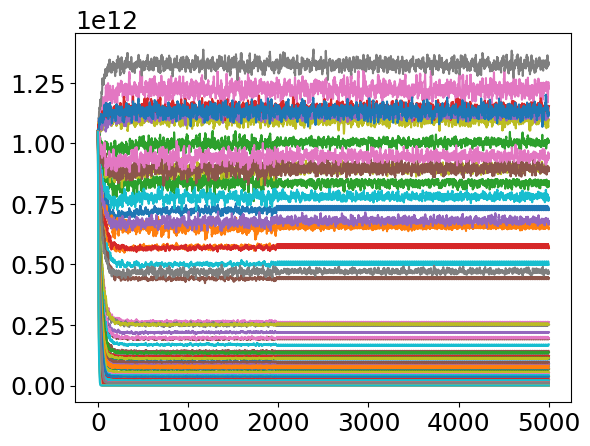

In [322]:
plt.plot(ds_reg_models_med_vol.sel(rgi_reg='02'));

In [323]:
# test without Zeokllari and OGGM-VAS
sel = False
if sel:
    glac_models = ['James', 'Rounce', 'Compagno', 'Kraaijenbrink', 'GLIMB', 'OGGM_v16'] #, 'OGGM-VAS', 'Zekollari'] # OGGM_v153, Huss
    ds_reg_models = ds_reg_models.sel(model_author=glac_models)
    ds_reg_models_vol = ds_reg_models.volume_m3.isel(simulation_year=slice(0,2000)) #['relative volume change (in %)']

    # Let's take the median estimate from all glacier models for every RGI region and then do the sum:
    ds_reg_models_vol = ds_reg_models_vol.stack(experiments=['gcm','period_scenario'])
    ds_reg_models_med_vol = ds_reg_models_vol.median(dim='model_author')
    num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5:'(f)', 6:'(g)', 7:'(h)', 8:'(i)', 9:'(j)', 10:'(k)', 11:'(l)', 12:'(m)'} 


In [324]:
def get_vol_timeseries_temp_ch_Xyr_glob_glacier(region='global', perc=90):
    
    q1=(50-perc/2)/100
    q2=(50+perc/2)/100
    
    
    plt.rc('font', size=18)  
    fig,axs= plt.subplots(1,2,figsize=(24,8),sharey=True)

    ax = axs[0]
    # get global temp. change
    pd_global_temp_exp_m = get_glob_temp_exp(region='global')
    if region == 'global':
        # get global glacier temp.change
        pd_global_temp_exp_m_glac = get_glob_temp_exp(region='global_glacier')
        ds_reg_models_med_vol_sel = ds_reg_models_med_vol.sum(dim='rgi_reg')
        n_models = ''
    else:
        # get regional glacier temp. change
        pd_global_temp_exp_m_glac = get_glob_temp_exp(region=region)
        rgi_reg = region[3:5]
        ds_reg_models_med_vol_sel = ds_reg_models_med_vol.sel(rgi_reg=rgi_reg)
        # check how many glacier models have at least some estimates
        reg_glac_models = ds_reg_models_vol.sel(rgi_reg=rgi_reg).dropna(dim='model_author', how='all').model_author
        print(reg_glac_models.values)
        n_models = len(reg_glac_models)
        n_models = f'{n_models} '


    ds_reg_models_med_vol_sel = ds_reg_models_med_vol_sel.assign_coords(temp_ch_ipcc = ('experiments',
                                                                          pd_global_temp_exp_m.loc[ds_reg_models_med_vol_sel.experiments, # make sure thatwe use the same experiments
                                                                                                   'temp_ch_ipcc']))
    ds_reg_models_med_vol_sel = ds_reg_models_med_vol_sel.assign_coords(temp_ch_ipcc_glacier = ('experiments',
                                                                          pd_global_temp_exp_m_glac.loc[ds_reg_models_med_vol_sel.experiments, # make sure thatwe use the same experiments
                                                                                                 'temp_ch_ipcc']))
    # need that to have bot volume_m3 and temp_ch_ipcc as variables
    ds_reg_models_med_vol_sel = ds_reg_models_med_vol_sel.reset_coords()
    init_vol = ds_reg_models_med_vol_sel.volume_m3.isel(simulation_year=0)
    ds_reg_models_med_vol_sel['relative volume change (in %)'] = 100*ds_reg_models_med_vol_sel.volume_m3/init_vol

    pd_t =ds_reg_models_med_vol_sel.to_dataframe().reset_index()
    #pd_t['volume (km3)'] = pd_t['volume_m3']/1e9

    g = sns.lineplot(ax=ax,
                 data=pd_t,
                 x='simulation_year',
                 y='relative volume change (in %)', #'volume (km3)',
                hue='temp_ch_ipcc', palette='flare',legend=False,lw=1, alpha = 0.7);

    ## get colormap 
    norm = plt.Normalize(vmin=pd_global_temp_exp_m['temp_ch_ipcc'].min(),
                         vmax=pd_global_temp_exp_m['temp_ch_ipcc'].max())
    cmap = sns.color_palette('flare', as_cmap=True) #sns.cubehelix_palette(light=1, as_cmap=True)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.02, ax.get_position().height / 2.1])
    cbar = ax.figure.colorbar(sm, cax=cax)
    cbar.ax.invert_yaxis()
    cbar.set_ticks([0,1.5,3.0,4.5,6.0])
    
    # plot specific delta T:
    col_temp_l = []
    exp_l = []
    for temp in [0,1.5,2,3,4,5]: #,5,6]:
        exp = np.abs(pd_global_temp_exp_m-temp).sort_values(by='temp_ch_ipcc').iloc[0].name
        col_temp = cmap(sm.colorbar.norm(pd_global_temp_exp_m.loc[exp]['temp_ch_ipcc']))
        col_temp_l.append(col_temp)
        exp_l.append(exp)
    pd_t_sel =ds_reg_models_med_vol_sel.sel(experiments=exp_l).to_dataframe().reset_index()
    #pd_t_sel['volume (km3)'] = pd_t_sel['volume_m3']/1e9
    l_sel = sns.lineplot(ax=ax,
                 data=pd_t_sel,
                 x='simulation_year',
                 y='relative volume change (in %)', #'volume (km3)',
                hue='temp_ch_ipcc', palette=sns.color_palette(col_temp_l),
                 legend='auto',lw=5, ls='--');
    ax.legend(loc='upper left', bbox_to_anchor=(1.005,0.99), markerscale=1, handleheight=0.8)
    leg = ax.get_legend()
    for j,t in enumerate(leg.texts):
        # truncate label text to 4 characters
        if j ==1:
            t.set_text(np.round(float(t.get_text()),1))
        else:
            t.set_text(np.round(float(t.get_text()),0))
    # set the linewidth of each legend object
    for legobj in leg.legendHandles:
        legobj.set_linewidth(4.0)
        legobj.set_linestyle('--')
    #g.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), ncol=1)

    exp_temp_min = ds_reg_models_med_vol_sel.temp_ch_ipcc.idxmin()
    # only compute the quantile for the experiment w. minimum / maximum temperature, then just sum up the quantiles to get from regional to global estimates
    q1_2_min = ds_reg_models_vol.sel(experiments=exp_temp_min).quantile([q1,q2], dim='model_author')/1e9
    if region == 'global':
        q1_2_min_glob = q1_2_min.sum(dim='rgi_reg')
    else:
        q1_2_min_glob = q1_2_min.sel(rgi_reg=rgi_reg)
    q1_2_min_glob = (100*q1_2_min_glob/q1_2_min_glob.isel(simulation_year=0))
    ax.fill_between(ds_reg_models_med_vol_sel.simulation_year,
             q1_2_min_glob.sel(quantile=q1), q1_2_min_glob.sel(quantile=q2), alpha = 0.2, color=l_sel.lines[0].get_color())
    #handles, labels = ax.get_legend_handles_labels()
    #t = plt.legend(handles, labels)
    #ax.add_artist(leg)

    exp_temp_max = ds_reg_models_med_vol_sel.temp_ch_ipcc.idxmax()
    # only compute the quantile for the experiment w. minimum / maximum temperature, then just sum up the quantiles to get from regional to global estimates
    q1_2_max = ds_reg_models_vol.sel(experiments=exp_temp_max).quantile([q1,q2], dim='model_author')/1e9
    if region == 'global':
        q1_2_max_glob = q1_2_max.sum(dim='rgi_reg')
    else:
        q1_2_max_glob = q1_2_max.sel(rgi_reg=rgi_reg)
    q1_2_max_glob = (100*q1_2_max_glob/q1_2_max_glob.isel(simulation_year=0))

    ax.fill_between(ds_reg_models_med_vol_sel.simulation_year,
             q1_2_max_glob.sel(quantile=q1), q1_2_max_glob.sel(quantile=q2), alpha = 0.2, color=l_sel.lines[-1].get_color());
    if region == 'global':
        ax.set_ylabel(f'Global glacier relative volume change (in %)')
    else:
        ax.set_ylabel(f'RGI{rgi_reg} glacier relative volume change (in %)')
    ax.set_xlabel('Simulation year')
    #ax.legend(loc='upper left', bbox_to_anchor=(1.01,0.98))
    #leg = ax.get_legend()
    #leg.loc('upper right')
    leg.set_title(r'$\Delta$T (°C)'+f'\n(global)')

    # add additional legend for glacier model uncertatinties and other things ... 
    #define patches and lines to add to legend
    #patch_min = mpatches.Patch(label=f'{perc}th %-ile minimum temperature',  alpha = 0.2, color=l.lines[0].get_color())
    patch_max = mpatches.Patch(label=f'{perc}th %-ile of {n_models}glacier models',  alpha = 0.2, color='grey')
    line1 = Line2D([0], [0], label=f'median of {n_models}glacier models', color='black', lw=1, alpha = 0.7)
    line2 = Line2D([0], [0], label=r'experiment nearest to $\Delta$T', color='black', lw=5, alpha = 0.8, ls = '--')
    #add handles
    handles= [line1, line2, patch_max]
    #add legend
    ax.legend(handles=handles, title='n=80 experiments', loc='upper center')
    ax.add_artist(leg)

    
    ########################## Second subplot
    ax=axs[1]
    if region == 'global':
        ax.set_title(f'Global glacier relative volume change after 2000 years')
    else:
        ax.set_title(f'RGI{rgi_reg} glacier relative volume change after 2000 years')
    sns.scatterplot(ax=ax,
                    x='temp_ch_ipcc',
                 y='relative volume change (in %)', #'volume (km3)',
                    data = pd_t.loc[pd_t.simulation_year==1999],
                hue='temp_ch_ipcc', palette='flare',legend=False, s=80)
    ax.set_xlabel(r'$\Delta$T$_{global}$ (°C, compared to pre-industrial levels)')
    #ax.get_legend().set_title(r'$\Delta$T (°C)');

    q1_2_2000 = ds_reg_models_vol.isel(simulation_year=1999).quantile([q1,q2], dim='model_author')
    if region == 'global':
        q1_2_2000_glob = q1_2_2000.sum(dim='rgi_reg')
    else:
        q1_2_2000_glob = q1_2_2000.sel(rgi_reg=rgi_reg)

    q1_2_2000_glob = q1_2_2000_glob.assign_coords(temp_ch_ipcc = ('experiments',
                                                   pd_global_temp_exp_m.loc[ds_reg_models_med_vol_sel.experiments.values, 'temp_ch_ipcc'].values))
    q1_2_2000_glob = q1_2_2000_glob.reset_coords()
    # init_vol is the same
    q1_2_2000_glob['relative volume change (in %)'] = 100*q1_2_2000_glob.volume_m3/init_vol[0]

    q1_2_2000_glob = q1_2_2000_glob.sortby('temp_ch_ipcc')
    def smoothen(x, winsize=1):
        return np.array(pd.Series(x).rolling(winsize).mean())[winsize-1:]

    ax.fill_between(smoothen(q1_2_2000_glob.temp_ch_ipcc),
                     smoothen(q1_2_2000_glob['relative volume change (in %)'].sel(quantile=q1)),
                     smoothen(q1_2_2000_glob['relative volume change (in %)'].sel(quantile=q2)),
                     #step='mid',
                     #interpolate=True,
                     alpha = 0.2, color='grey');

    #define patches and lines to add to legend
    line1 = Line2D([0], [0], label='median', color='black', ms=10, marker='o', lw=0,alpha = 0.8)
    patch = mpatches.Patch(label=f'{perc}th %-ile',  alpha = 0.2, color='grey')
    #line1 = Line2D([0], [0], label='First Manual Line', color='purple')
    #add handles
    handles= [line1,patch]
    #add legend
    ax.legend(handles=handles, title=f'{n_models}glacier models', loc = 'upper left', bbox_to_anchor=(0.15,1))
    pd_t_sel_1_4 = pd_t.loc[(pd_t.temp_ch_ipcc>=1) & (pd_t.temp_ch_ipcc<=4)]
    pd_t_sel_1_4 = pd_t_sel_1_4.loc[pd_t_sel_1_4.simulation_year==1999]
    slope, intercept, rval, pval, stderr = scipy.stats.linregress(pd_t_sel_1_4['temp_ch_ipcc'].values, pd_t_sel_1_4['relative volume change (in %)'])
    ax.plot(pd_t_sel_1_4['temp_ch_ipcc'], slope*pd_t_sel_1_4['temp_ch_ipcc'].values + intercept, color = 'black', alpha = 0.7, lw=4)
    ax.annotate(f'{slope:.0f}% more lost\nper °C additional\nglobal warming',
                xy=(2,slope*2 + intercept),xytext=(2+0.5,slope*2 + intercept+5),
               arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=0.3"), color='black', alpha=0.7)

    
    ################ 3rd inset subplot ##############
    inset_ax = inset_axes(ax,
                        width="35%", # width = 30% of parent_bbox
                        height="45%", # height : 1 inch
                        loc='upper right'
                           #bbox_to_anchor=(1,)
                           )
    sns.scatterplot(data=pd_t, ax = inset_ax,
                    x='temp_ch_ipcc', y='temp_ch_ipcc_glacier', hue='temp_ch_ipcc', palette='flare',legend=False)
    #inset_axes.set_title(f'Glacier area-weighted vs global\n'+r'temperature changes ($\Delta$T)'+'\ncompared to preindustrial levels')
    inset_ax.set_xlabel(r'$\Delta$T$_{global}$ (°C)')# + '\n(°C, compared to pre-industrial levels)')
    if region == 'global':
        inset_ax.set_ylabel(r'$\Delta$T$_{glacier}$ (°C)'+'\n(area-weighted)')
    else:
        inset_ax.set_ylabel(r'$\Delta$T$_{glacier}$ '+f'RGI{rgi_reg} (°C)\n(area-weighted)')
    inset_ax.grid(alpha=0.5)
    # add linear fit
    slope, intercept, rval, pval, stderr = scipy.stats.linregress(pd_t['temp_ch_ipcc'].values, pd_t['temp_ch_ipcc_glacier'])
    inset_ax.plot(pd_t['temp_ch_ipcc'], slope*pd_t['temp_ch_ipcc'].values + intercept, color = 'black', alpha = 0.5, lw=4)
    if region == 'global':
        inset_ax.annotate(f'{slope:.1f}°C '+r'$\Delta$T$_{glacier}$'+'\nper 1.0°C '+r'$\Delta$T$_{global}$',
                          xy=(3,slope*3 + intercept),
                          xytext=(4-2-0.5,slope*4 + intercept-8-0.25),
                   arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), color='black', alpha=0.7)
    else:
        inset_ax.annotate(f'{slope:.1f}°C '+r'$\Delta$T$_{glacier}$'+f'\nRGI{rgi_reg} per'+'\n1°C '+r'$\Delta$T$_{global}$',
                          xy=(3,slope*3 + intercept),
                          xytext=(0.4,0.04),    #(4-2,slope*4 + intercept-8),
                          textcoords='axes fraction',
                   arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), color='black', alpha=0.7)
    inset_ax.set_xticks(np.arange(0,pd_t['temp_ch_ipcc'].values.max(),2))
    inset_ax.set_yticks(np.arange(0,pd_t['temp_ch_ipcc_glacier'].values.max(),2))

    #inset_ax.add_artist(Line2D([pd_t.temp_ch_ipcc_glacier.min(), pd_t.temp_ch_ipcc_glacier.max()],
    #                           [pd_t.temp_ch_ipcc_glacier.min(), pd_t.temp_ch_ipcc_glacier.max()], color='grey'))

    # add a,b,c
    num_text_x = 0.007
    for j,axi in enumerate([axs[0],axs[1], inset_ax]):
        if j <2:
            num_text_y = 0.94
        else:
            num_text_y = 0.87
        axi.text(num_text_x, num_text_y,
                 num_dict[j], fontsize=26, transform=axi.transAxes)
    
    # plt.tight_layout()
    plt.savefig(f'figures/2_timeseries_temp_ch_reg_glob/2_{region}_timeseries_vol_temp_ch_{perc}%ile.png', bbox_inches='tight')
    plt.savefig(f'figures/2_timeseries_temp_ch_reg_glob/2_{region}_timeseries_vol_temp_ch_{perc}%ile.pdf', bbox_inches='tight')


In [325]:
#get_vol_timeseries_temp_ch_Xyr_glob_glacier(region='global', perc=90)

In [326]:
def get_vol_timeseries_temp_ch_Xyr_glob_glacier_portrait(region='global', perc=90, sim_year=2000, avg_last_20yr = False):
    
    q1=(50-perc/2)/100
    q2=(50+perc/2)/100
    
    
    plt.rc('font', size=24)  
    fig,axs= plt.subplots(2,1,figsize=(12,20))

    ax = axs[0]
    # get global temp. change
    pd_global_temp_exp_m = get_glob_temp_exp(region='global')
    if region == 'global':
        # get global glacier temp.change
        pd_global_temp_exp_m_glac = get_glob_temp_exp(region='global_glacier')
        ds_reg_models_med_vol_sel = ds_reg_models_med_vol.sum(dim='rgi_reg')
        n_models = ''
        rgi_reg = 'global'
    else:
        # get regional glacier temp. change
        pd_global_temp_exp_m_glac = get_glob_temp_exp(region=region)
        rgi_reg = region[3:5]
        ds_reg_models_med_vol_sel = ds_reg_models_med_vol.sel(rgi_reg=rgi_reg)
        # check how many glacier models have at least some estimates
        reg_glac_models = ds_reg_models_vol.sel(rgi_reg=rgi_reg).dropna(dim='model_author', how='all').model_author
        print(reg_glac_models.values)
        n_models = len(reg_glac_models)
        n_models = f'{n_models} '


    ds_reg_models_med_vol_sel = ds_reg_models_med_vol_sel.assign_coords(temp_ch_ipcc = ('experiments',
                                                                          pd_global_temp_exp_m.loc[ds_reg_models_med_vol_sel.experiments, # make sure thatwe use the same experiments
                                                                                                   'temp_ch_ipcc']))
    ds_reg_models_med_vol_sel = ds_reg_models_med_vol_sel.assign_coords(temp_ch_ipcc_glacier = ('experiments',
                                                                          pd_global_temp_exp_m_glac.loc[ds_reg_models_med_vol_sel.experiments, # make sure thatwe use the same experiments
                                                                                                 'temp_ch_ipcc']))
    # need that to have bot volume_m3 and temp_ch_ipcc as variables
    ds_reg_models_med_vol_sel = ds_reg_models_med_vol_sel.reset_coords()
    init_vol = ds_reg_models_med_vol_sel.volume_m3.isel(simulation_year=0)
    ds_reg_models_med_vol_sel['relative volume change (in %)'] = 100*ds_reg_models_med_vol_sel.volume_m3/init_vol

    pd_t =ds_reg_models_med_vol_sel.to_dataframe().reset_index()
    #pd_t['volume (km3)'] = pd_t['volume_m3']/1e9

    g = sns.lineplot(ax=ax,
                 data=pd_t,
                 x='simulation_year',
                 y='relative volume change (in %)', #'volume (km3)',
                hue='temp_ch_ipcc', palette='flare',legend=False,lw=1, alpha = 0.7);

    ## get colormap 
    norm = plt.Normalize(vmin=pd_global_temp_exp_m['temp_ch_ipcc'].min(),
                         vmax=pd_global_temp_exp_m['temp_ch_ipcc'].max())
    cmap = sns.color_palette('flare', as_cmap=True) #sns.cubehelix_palette(light=1, as_cmap=True)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cax = fig.add_axes([ax.get_position().x1-0.12, ax.get_position().y0+0.005, 0.02, ax.get_position().height / 2.6])
    cbar = ax.figure.colorbar(sm, cax=cax)
    cbar.ax.invert_yaxis()
    cbar.set_ticks([0,1.5,3.0,4.5,6.0])
    cbar.set_label(r'$\Delta$T (°C, global)')
    
    # plot specific delta T:
    col_temp_l = []
    exp_l = []
    for temp in [0,1.5,2,3,4,5]: #,5,6]:
        exp = np.abs(pd_global_temp_exp_m-temp).sort_values(by='temp_ch_ipcc').iloc[0].name
        col_temp = cmap(sm.colorbar.norm(pd_global_temp_exp_m.loc[exp]['temp_ch_ipcc']))
        col_temp_l.append(col_temp)
        exp_l.append(exp)
    pd_t_sel =ds_reg_models_med_vol_sel.sel(experiments=exp_l).to_dataframe().reset_index()
    #pd_t_sel['volume (km3)'] = pd_t_sel['volume_m3']/1e9
    l_sel = sns.lineplot(ax=ax,
                 data=pd_t_sel,
                 x='simulation_year',
                 y='relative volume change (in %)', #'volume (km3)',
                hue='temp_ch_ipcc', palette=sns.color_palette(col_temp_l),
                 legend='auto',lw=5, ls='--');
    ax.legend(loc='upper right', bbox_to_anchor=(1,1), markerscale=1, handleheight=0.8)
    leg = ax.get_legend()
    for j,t in enumerate(leg.texts):
        # truncate label text to 4 characters
        if j ==1:
            t.set_text(np.round(float(t.get_text()),1))
        else:
            t.set_text(np.round(float(t.get_text()),0))
    # set the linewidth of each legend object
    for legobj in leg.legendHandles:
        legobj.set_linewidth(4.0)
        legobj.set_linestyle('--')
    #g.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), ncol=1)

    exp_temp_min = ds_reg_models_med_vol_sel.temp_ch_ipcc.idxmin()
    # only compute the quantile for the experiment w. minimum / maximum temperature, then just sum up the quantiles to get from regional to global estimates
    q1_2_min = ds_reg_models_vol.sel(experiments=exp_temp_min).quantile([q1,q2], dim='model_author')/1e9
    if region == 'global':
        q1_2_min_glob = q1_2_min.sum(dim='rgi_reg')
    else:
        q1_2_min_glob = q1_2_min.sel(rgi_reg=rgi_reg)
    q1_2_min_glob = (100*q1_2_min_glob/q1_2_min_glob.isel(simulation_year=0))
    ax.fill_between(ds_reg_models_med_vol_sel.simulation_year,
             q1_2_min_glob.sel(quantile=q1), q1_2_min_glob.sel(quantile=q2), alpha = 0.2, color=l_sel.lines[0].get_color())
    #handles, labels = ax.get_legend_handles_labels()
    #t = plt.legend(handles, labels)
    #ax.add_artist(leg)

    exp_temp_max = ds_reg_models_med_vol_sel.temp_ch_ipcc.idxmax()
    # only compute the quantile for the experiment w. minimum / maximum temperature, then just sum up the quantiles to get from regional to global estimates
    q1_2_max = ds_reg_models_vol.sel(experiments=exp_temp_max).quantile([q1,q2], dim='model_author')/1e9
    if region == 'global':
        q1_2_max_glob = q1_2_max.sum(dim='rgi_reg')
    else:
        q1_2_max_glob = q1_2_max.sel(rgi_reg=rgi_reg)
    q1_2_max_glob = (100*q1_2_max_glob/q1_2_max_glob.isel(simulation_year=0))

    ax.fill_between(ds_reg_models_med_vol_sel.simulation_year,
             q1_2_max_glob.sel(quantile=q1), q1_2_max_glob.sel(quantile=q2), alpha = 0.2, color=l_sel.lines[-1].get_color());
    if region == 'global':
        ax.set_ylabel(f'Global glacier volume change (in %, relative to 2020)')
    else:
        ax.set_ylabel(f'RGI{rgi_reg} glacier volume change (in %, relative to 2020)')
    ax.set_xlabel('Simulation year')
    #ax.legend(loc='upper left', bbox_to_anchor=(1.01,0.98))
    #leg = ax.get_legend()
    #leg.loc('upper right')
    leg.set_title(r'$\Delta$T (°C)'+f'\n(global)')

    # add additional legend for glacier model uncertatinties and other things ... 
    #define patches and lines to add to legend
    #patch_min = mpatches.Patch(label=f'{perc}th %-ile minimum temperature',  alpha = 0.2, color=l.lines[0].get_color())
    patch_max = mpatches.Patch(label=f'{perc}th %-ile of {n_models}glacier models',  alpha = 0.2, color='grey')
    line1 = Line2D([0], [0], label=f'median of {n_models}glacier models', color='black', lw=1, alpha = 0.7)
    line2 = Line2D([0], [0], label=r'experiment nearest to $\Delta$T', color='black', lw=5, alpha = 0.8, ls = '--')
    #add handles
    handles= [line1, line2, patch_max]
    #add legend
    ax.legend(handles=handles, title='n=80 experiments', loc='upper left', bbox_to_anchor=(0.1,1))
    ax.add_artist(leg)
    
    if region == 'global':
        ax.set_title(f'Global glacier volume equilibration experiments')
    else:
        ax.set_title(f'RGI{rgi_reg} glacier volume equilibration experiments')
    if sim_year == 2000:
        ax.set_xlim(ax.get_xlim()[0], 2600)
        ax.set_xticks(np.arange(0,2100,500),np.arange(0,2100,500))
    else:
        ax.set_xlim(ax.get_xlim()[0], 6400)
        ax.set_xticks(np.arange(0,5100,1000),np.arange(0,5100,1000))
    ########################## Second subplot
    ax=axs[1]
    if region == 'global':
        ax.set_title(f'Global glacier volume after {sim_year} years')
    else:
        ax.set_title(f'RGI{rgi_reg} glacier volume after {sim_year} years')
    sns.scatterplot(ax=ax,
                    x='temp_ch_ipcc',
                 y='relative volume change (in %)', #'volume (km3)',
                    data = pd_t.loc[pd_t.simulation_year==sim_year],
                hue='temp_ch_ipcc', palette='flare',legend=False, s=80)
    ax.set_xlabel(r'$\Delta$T$_{global}$ (°C, compared to pre-industrial levels)')
    #ax.get_legend().set_title(r'$\Delta$T (°C)');

    q1_2_2000 = ds_reg_models_vol.isel(simulation_year=sim_year).quantile([q1,q2], dim='model_author')
    if region == 'global':
        q1_2_2000_glob = q1_2_2000.sum(dim='rgi_reg')
    else:
        q1_2_2000_glob = q1_2_2000.sel(rgi_reg=rgi_reg)

    q1_2_2000_glob = q1_2_2000_glob.assign_coords(temp_ch_ipcc = ('experiments',
                                                   pd_global_temp_exp_m.loc[ds_reg_models_med_vol_sel.experiments.values, 'temp_ch_ipcc'].values))
    q1_2_2000_glob = q1_2_2000_glob.reset_coords()
    # init_vol is the same
    q1_2_2000_glob['relative volume change (in %)'] = 100*q1_2_2000_glob.volume_m3/init_vol[0]

    q1_2_2000_glob = q1_2_2000_glob.sortby('temp_ch_ipcc')
    def smoothen(x, winsize=1):
        return np.array(pd.Series(x).rolling(winsize).mean())[winsize-1:]

    ax.fill_between(smoothen(q1_2_2000_glob.temp_ch_ipcc),
                     smoothen(q1_2_2000_glob['relative volume change (in %)'].sel(quantile=q1)),
                     smoothen(q1_2_2000_glob['relative volume change (in %)'].sel(quantile=q2)),
                     #step='mid',
                     #interpolate=True,
                     alpha = 0.2, color='grey');

    #define patches and lines to add to legend
    line1 = Line2D([0], [0], label='median', color='black', ms=10, marker='o', lw=0,alpha = 0.8)
    patch = mpatches.Patch(label=f'{perc}th %-ile',  alpha = 0.2, color='grey')
    #line1 = Line2D([0], [0], label='First Manual Line', color='purple')
    #add handles
    handles= [line1,patch]
    #add legend
    ax.legend(handles=handles, title=f'{n_models}glacier models', loc = 'upper left', bbox_to_anchor=(0.1,1))
    pd_t_sel_1o5_3 = pd_t.loc[(pd_t.temp_ch_ipcc>=1.5) & (pd_t.temp_ch_ipcc<=3)]
    pd_t_sel_1o5_3 = pd_t_sel_1o5_3.loc[pd_t_sel_1o5_3.simulation_year==sim_year]
    slope, intercept, rval, pval, stderr = scipy.stats.linregress(pd_t_sel_1o5_3['temp_ch_ipcc'].values, pd_t_sel_1o5_3['relative volume change (in %)'])
    ax.plot(pd_t_sel_1o5_3['temp_ch_ipcc'], slope*pd_t_sel_1o5_3['temp_ch_ipcc'].values + intercept, color = 'black', alpha = 0.7, lw=4)
    
    if rgi_reg not in ['01','04','03','05','14','17','19', 'global']:
        ax.annotate(f'{slope:.0f}% more lost\nper °C additional\nglobal warming',
                    xy=(2,slope*2 + intercept),xytext=(2,50),
                   arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=0.3"), color='black', alpha=0.95)
    elif rgi_reg in ['04']:
        ax.annotate(f'{slope:.0f}% more lost\nper °C additional\nglobal warming',
                    xy=(2,slope*2 + intercept),xytext=(2,30),
                   arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=0.3"), color='black', alpha=0.95)
    else:
        ax.annotate(f'{slope:.0f}% more lost\nper °C additional\nglobal warming',
                    xy=(2,slope*2 + intercept),xytext=(-0.25,0),
                   arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=0.3"), color='black', alpha=0.95)

    
    ################ 3rd inset subplot ##############
    #plt.tight_layout()
    inset_ax = inset_axes(ax,
                        width="38%", # width = 30% of parent_bbox
                        height="48%", # height : 1 inch
                        loc='upper right'
                           #bbox_to_anchor=(1,)
                           )
    sns.scatterplot(data=pd_t, ax = inset_ax,
                    x='temp_ch_ipcc', y='temp_ch_ipcc_glacier', hue='temp_ch_ipcc', palette='flare',legend=False)
    #inset_axes.set_title(f'Glacier area-weighted vs global\n'+r'temperature changes ($\Delta$T)'+'\ncompared to preindustrial levels')
    inset_ax.set_xlabel(r'$\Delta$T$_{global}$ (°C)')# + '\n(°C, compared to pre-industrial levels)')
    if region == 'global':
        inset_ax.set_ylabel(r'$\Delta$T$_{glacier}$ (°C)'+'\n(area-weighted)')
    else:
        inset_ax.set_ylabel(r'$\Delta$T$_{glacier}$ '+f'RGI{rgi_reg} (°C)\n(area-weighted)')
    inset_ax.grid(alpha=0.5)
    # add linear fit
    slope, intercept, rval, pval, stderr = scipy.stats.linregress(pd_t['temp_ch_ipcc'].values, pd_t['temp_ch_ipcc_glacier'])
    inset_ax.plot(pd_t['temp_ch_ipcc'], slope*pd_t['temp_ch_ipcc'].values + intercept, color = 'black', alpha = 0.5, lw=4)
    if region == 'global':
        inset_ax.annotate(f'{slope:.1f}°C '+r'$\Delta$T$_{glacier}$'+'\nper 1.0°C '+r'$\Delta$T$_{global}$',
                          xy=(3,slope*3 + intercept),
                          xytext=(4-2-0.5,slope*4 + intercept-8-0.25),
                          fontsize = 21,
                   arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), color='black', alpha=0.7)
    else:
        inset_ax.annotate(f'{slope:.1f}°C '+r'$\Delta$T$_{glacier}$'+f'\nRGI{rgi_reg} per'+'\n1°C '+r'$\Delta$T$_{global}$',
                          xy=(3,slope*3 + intercept),
                          xytext=(0.4,0.04),    #(4-2,slope*4 + intercept-8),
                          textcoords='axes fraction', fontsize=20,
                   arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), color='black', alpha=0.7)
    inset_ax.set_xticks(np.arange(0,pd_t['temp_ch_ipcc'].values.max(),2))
    inset_ax.set_yticks(np.arange(0,pd_t['temp_ch_ipcc_glacier'].values.max(),2))

    #inset_ax.add_artist(Line2D([pd_t.temp_ch_ipcc_glacier.min(), pd_t.temp_ch_ipcc_glacier.max()],
    #                           [pd_t.temp_ch_ipcc_glacier.min(), pd_t.temp_ch_ipcc_glacier.max()], color='grey'))

    # add a,b,c
    num_text_x = 0.007
    for j,axi in enumerate([axs[0],axs[1], inset_ax]):
        if j <2:
            num_text_y = 0.94
        else:
            num_text_y = 0.87
        axi.text(num_text_x, num_text_y,
                 num_dict[j], fontsize=26, transform=axi.transAxes)
    
    if region == 'global':
        for ax in axs:
            ax.set_ylabel('Glacier volume (in %)')
            ax.set_yticks(np.arange(0,160,25),np.arange(0,160,25))

    # plt.tight_layout()
    #plt.savefig(f'/home/www/lschuster/glacierMIP3_analysis/2_{region}_timeseries_vol_temp_ch_{perc}percentile_portrait.png', bbox_inches='tight')
    plt.savefig(f'figures/2_timeseries_temp_ch_reg_glob/2_{region}_timeseries_vol_temp_ch_{perc}percentile_portrait_{sim_year}yr.png', bbox_inches='tight')
    #plt.savefig(f'figures/2_timeseries_temp_ch_reg_glob/2_{region}_timeseries_vol_temp_ch_{perc}percentile_portrait_{sim_year}yr.pdf', bbox_inches='tight')


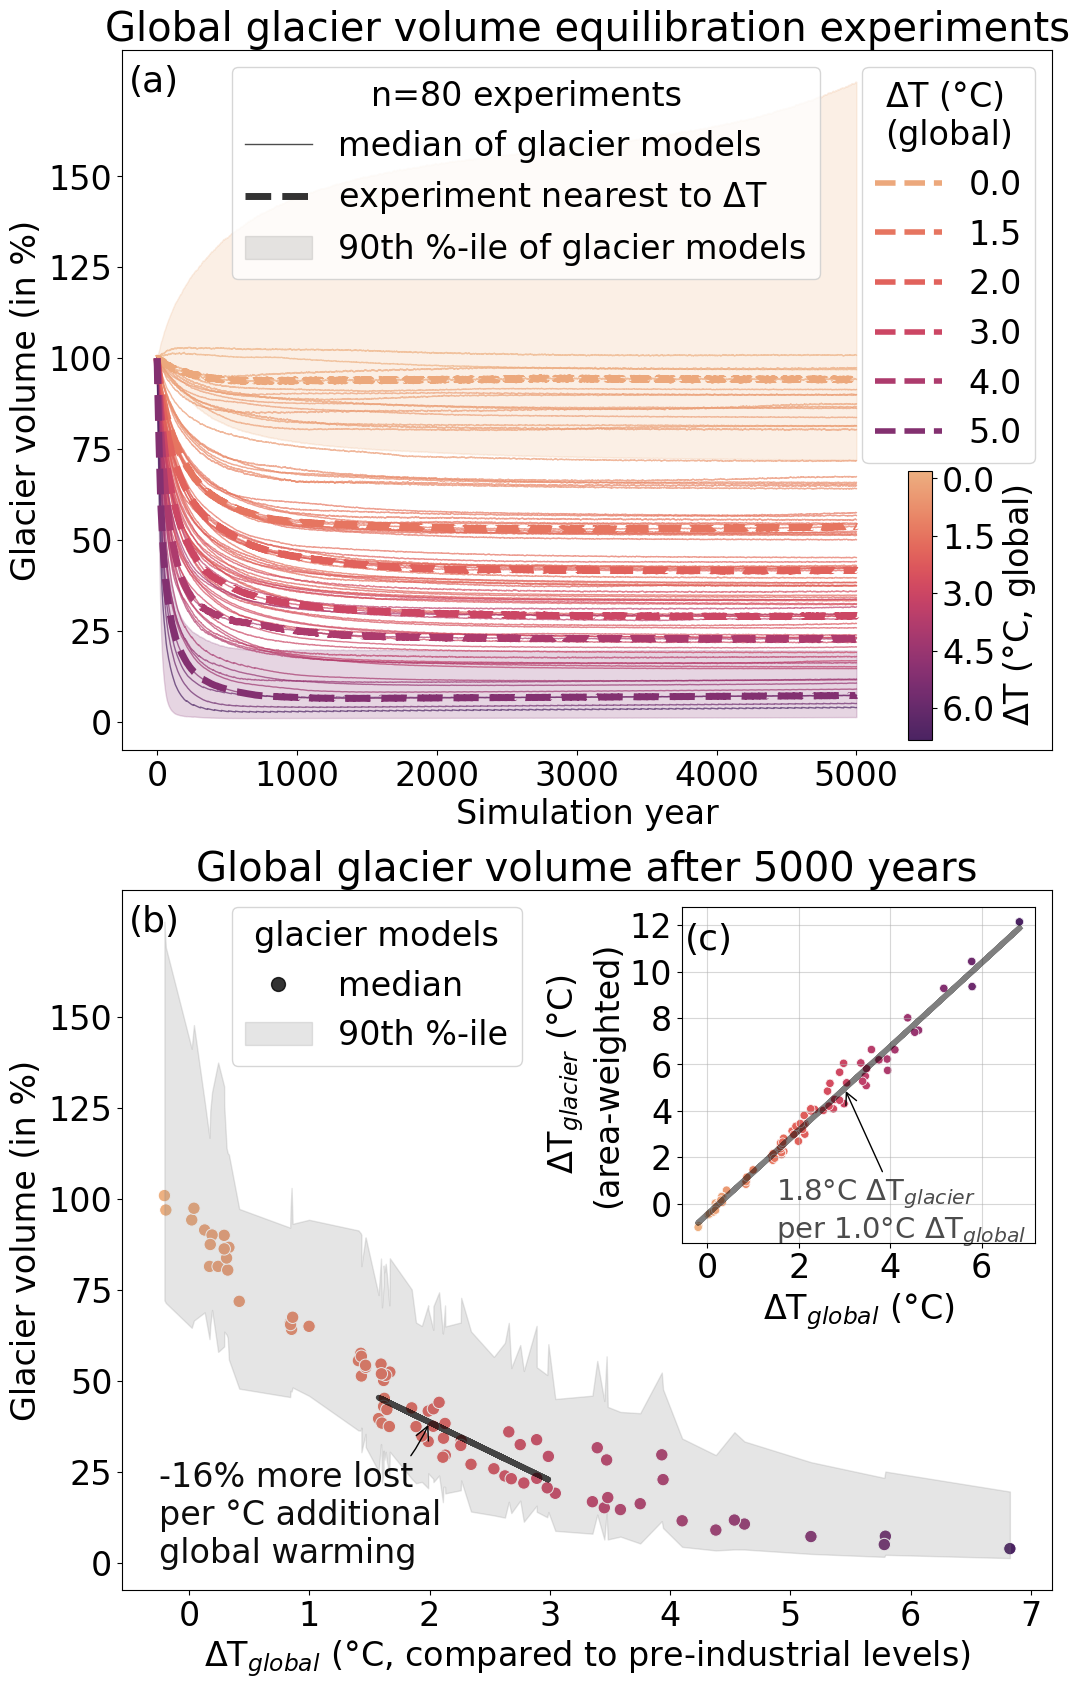

In [37]:
get_vol_timeseries_temp_ch_Xyr_glob_glacier_portrait(region='global', perc=90, sim_year=5000)

In [38]:
rgi_regs = []
for rgi_reg in np.arange(1,20,1):
    if rgi_reg < 10:
        rgi_reg = '0'+str(rgi_reg)
    else:
        rgi_reg = str(rgi_reg)
    rgi_regs.append(rgi_reg)
    
for rgi_reg in rgi_regs:
    #get_vol_timeseries_temp_ch_Xyr_glob_glacier(region=f'RGI{rgi_reg}_glacier', perc=90)
    get_vol_timeseries_temp_ch_Xyr_glob_glacier_portrait(region=f'RGI{rgi_reg}_glacier', perc=90, sim_year=5000)
    plt.close()

['Rounce' 'Compagno' 'GLIMB' 'OGGM_v16' 'OGGM-VAS']
['Rounce' 'Compagno' 'GLIMB' 'OGGM_v16' 'OGGM-VAS' 'Zekollari']
['Rounce' 'Compagno' 'GLIMB' 'OGGM_v16' 'OGGM-VAS']
['Rounce' 'Compagno' 'GLIMB' 'OGGM_v16' 'OGGM-VAS']
['Rounce' 'Compagno' 'GLIMB' 'OGGM_v16' 'OGGM-VAS']
['James' 'Rounce' 'Compagno' 'GLIMB' 'OGGM_v16' 'OGGM-VAS' 'Zekollari']
['Rounce' 'Compagno' 'GLIMB' 'OGGM_v16' 'OGGM-VAS']
['Rounce' 'Compagno' 'GLIMB' 'OGGM_v16' 'OGGM-VAS' 'Zekollari']
['Rounce' 'Compagno' 'GLIMB' 'OGGM_v16' 'OGGM-VAS']
['Rounce' 'Compagno' 'GLIMB' 'OGGM_v16' 'OGGM-VAS' 'Zekollari']
['Rounce' 'Compagno' 'GLIMB' 'OGGM_v16' 'OGGM-VAS' 'Zekollari']
['Rounce' 'Compagno' 'GLIMB' 'OGGM_v16' 'OGGM-VAS' 'Zekollari']
['Rounce' 'Compagno' 'Kraaijenbrink' 'GLIMB' 'OGGM_v16' 'OGGM-VAS']
['Rounce' 'Compagno' 'Kraaijenbrink' 'GLIMB' 'OGGM_v16' 'OGGM-VAS']
['Rounce' 'Compagno' 'Kraaijenbrink' 'GLIMB' 'OGGM_v16' 'OGGM-VAS']
['Rounce' 'Compagno' 'GLIMB' 'OGGM_v16' 'OGGM-VAS' 'Zekollari']
['Rounce' 'Compagno' 'GLIMB'

- if the GMTs between 1.5 and 3°C, how much glacier volume is left per °C ? 
    - -16% of global glacier volume gets lost per degree warming in a 1.5 to 3° warmer world ...  

In [39]:
old = False
if old:
    rgi_regs = []
    for rgi_reg in np.arange(1,20,1):
        if rgi_reg < 10:
            rgi_reg = '0'+str(rgi_reg)
        else:
            rgi_reg = str(rgi_reg)
        rgi_regs.append(rgi_reg)

    for rgi_reg in rgi_regs:
        get_vol_timeseries_temp_ch_Xyr_glob_glacier(region=f'RGI{rgi_reg}_glacier', perc=90)

## Overview plot

In [45]:
sim_year = 5000 #2000

In [46]:
pd_global_temp_exp_m = get_glob_temp_exp(region='global')

ds_reg_models_vol = ds_reg_models.isel(simulation_year=slice(0,sim_year+1)).volume_m3
# Let's take the median/iqr estimate from all glacier models for every RGI region and then do the sum:
ds_reg_models_vol = ds_reg_models_vol.stack(experiments=['gcm','period_scenario'])

### regional 
ds_reg_models_med_vol_2000 = 100*ds_reg_models_vol.median(dim='model_author').sel(simulation_year=sim_year)/ds_reg_models_vol.median(dim='model_author').isel(simulation_year=0)
# this here takes a while
#ds_reg_models_gcm_q25_q50_q75_vol = ds_reg_models_gcm_vol.quantile([0.25,0.5,0.75], dim='model_author')
# pd_global_temp_exp_m = get_glob_temp_exp(region=f'RGI{rgi_reg}_global') # pd_global_temp_exp.groupby(['gcm','period_scenario']).mean()
ds_reg_models_med_vol_2000 = ds_reg_models_med_vol_2000.assign_coords(temp_ch_ipcc = ('experiments',
                                                                                       pd_global_temp_exp_m.loc[ds_reg_models_med_vol_2000.experiments.values, 'temp_ch_ipcc'].values))
ds_reg_models_med_vol_2000 = ds_reg_models_med_vol_2000.sortby('temp_ch_ipcc')
ds_reg_models_med_vol_2000 = ds_reg_models_med_vol_2000.reset_coords()
pd_reg_models_med_vol_2000 = ds_reg_models_med_vol_2000.to_dataframe().reset_index()
pd_reg_models_med_vol_2000['region'] = 'RGI' + pd_reg_models_med_vol_2000['rgi_reg']

### global
ds_glob_models_med_vol_2000 = 100*ds_reg_models_vol.median(dim='model_author').sel(simulation_year=sim_year).sum(dim='rgi_reg')/ds_reg_models_vol.median(dim='model_author').isel(simulation_year=0).sum(dim='rgi_reg')
ds_glob_models_med_vol_2000 = ds_glob_models_med_vol_2000.assign_coords(temp_ch_ipcc = ('experiments',
                                                                                pd_global_temp_exp_m.loc[ds_glob_models_med_vol_2000.experiments.values, 'temp_ch_ipcc'].values))
ds_glob_models_med_vol_2000 = ds_glob_models_med_vol_2000.sortby('temp_ch_ipcc')
ds_glob_models_med_vol_2000 = ds_glob_models_med_vol_2000.reset_coords()
pd_glob_models_med_vol_2000 = ds_glob_models_med_vol_2000.to_dataframe().reset_index()
pd_glob_models_med_vol_2000['region'] = 'global'

### concatenate both
pd_all_models_med_vol_2000 = pd.concat([pd_glob_models_med_vol_2000, pd_reg_models_med_vol_2000])

# get the % lost per °C (here from 1.5 - 3°C)
pd_all_models_med_vol_2000_sel_1o5_3 = pd_all_models_med_vol_2000.loc[(pd_all_models_med_vol_2000.temp_ch_ipcc>=1.5) & (pd_all_models_med_vol_2000.temp_ch_ipcc<=3)]

slope_rgi_dict = {}
pd_slope_rgi_reg_1o5_3 = pd.DataFrame(index=np.arange(0,20))
intercept_l = []
slope_l = []
rval_l = []
pval_l = []
stderr_l = []
region_l = []
for region in pd_all_models_med_vol_2000_sel_1o5_3.region.unique():
    pd_sel = pd_all_models_med_vol_2000_sel_1o5_3.loc[pd_all_models_med_vol_2000_sel_1o5_3.region==region]
    slope, intercept, rval, pval, stderr = scipy.stats.linregress(pd_sel['temp_ch_ipcc'].values, pd_sel['volume_m3'])
    slope_l.append(slope)
    intercept_l.append(intercept)
    stderr_l.append(stderr)
    rval_l.append(rval)
    pval_l.append(pval)
    region_l.append(region)
pd_slope_rgi_reg_1o5_3['slope'] = slope_l
pd_slope_rgi_reg_1o5_3['intercept'] = intercept_l
pd_slope_rgi_reg_1o5_3['stderr'] = stderr_l
pd_slope_rgi_reg_1o5_3['pval'] = pval_l
pd_slope_rgi_reg_1o5_3['rval'] = rval_l
pd_slope_rgi_reg_1o5_3['region'] = region_l


In [47]:
# get the % lost per °C (here from 1 - 4 °C)
pd_all_models_med_vol_2000_sel_1_4 = pd_all_models_med_vol_2000.loc[(pd_all_models_med_vol_2000.temp_ch_ipcc>=1) & (pd_all_models_med_vol_2000.temp_ch_ipcc<=4)]
#pd_reg_models_med_vol_2000_sel_1_4 = pd_reg_models_med_vol_2000.loc[(pd_reg_models_med_vol_2000.temp_ch_ipcc>=1) & (pd_reg_models_med_vol_2000.temp_ch_ipcc<=4)]
#pd_glob_models_med_vol_2000_sel_1_4 = pd_glob_models_med_vol_2000.loc[(pd_glob_models_med_vol_2000.temp_ch_ipcc>=1) & (pd_glob_models_med_vol_2000.temp_ch_ipcc<=4)]

slope_rgi_dict = {}
pd_slope_rgi_reg = pd.DataFrame(index=np.arange(0,20))
intercept_l = []
slope_l = []
rval_l = []
pval_l = []
stderr_l = []
region_l = []
for region in pd_all_models_med_vol_2000_sel_1_4.region.unique():
    pd_sel = pd_all_models_med_vol_2000_sel_1_4.loc[pd_all_models_med_vol_2000_sel_1_4.region==region]
    slope, intercept, rval, pval, stderr = scipy.stats.linregress(pd_sel['temp_ch_ipcc'].values, pd_sel['volume_m3'])
    slope_l.append(slope)
    intercept_l.append(intercept)
    stderr_l.append(stderr)
    rval_l.append(rval)
    pval_l.append(pval)
    region_l.append(region)
pd_slope_rgi_reg['slope'] = slope_l
pd_slope_rgi_reg['intercept'] = intercept_l
pd_slope_rgi_reg['stderr'] = stderr_l
pd_slope_rgi_reg['pval'] = pval_l
pd_slope_rgi_reg['rval'] = rval_l
pd_slope_rgi_reg['region'] = region_l

- in most cases, the temperature sensitivity is larger from 1.5 to 3°C

In [48]:
markers = ['^', 'X','s','o','D','v']

norm = plt.Normalize(vmin=pd_global_temp_exp_m['temp_ch_ipcc'].min(),
                     vmax=pd_global_temp_exp_m['temp_ch_ipcc'].max())
cmap = sns.color_palette('flare', as_cmap=True) #sns.cubehelix_palette(light=1, as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])


/tmp/ipykernel_3683469/3908470698.py:189: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


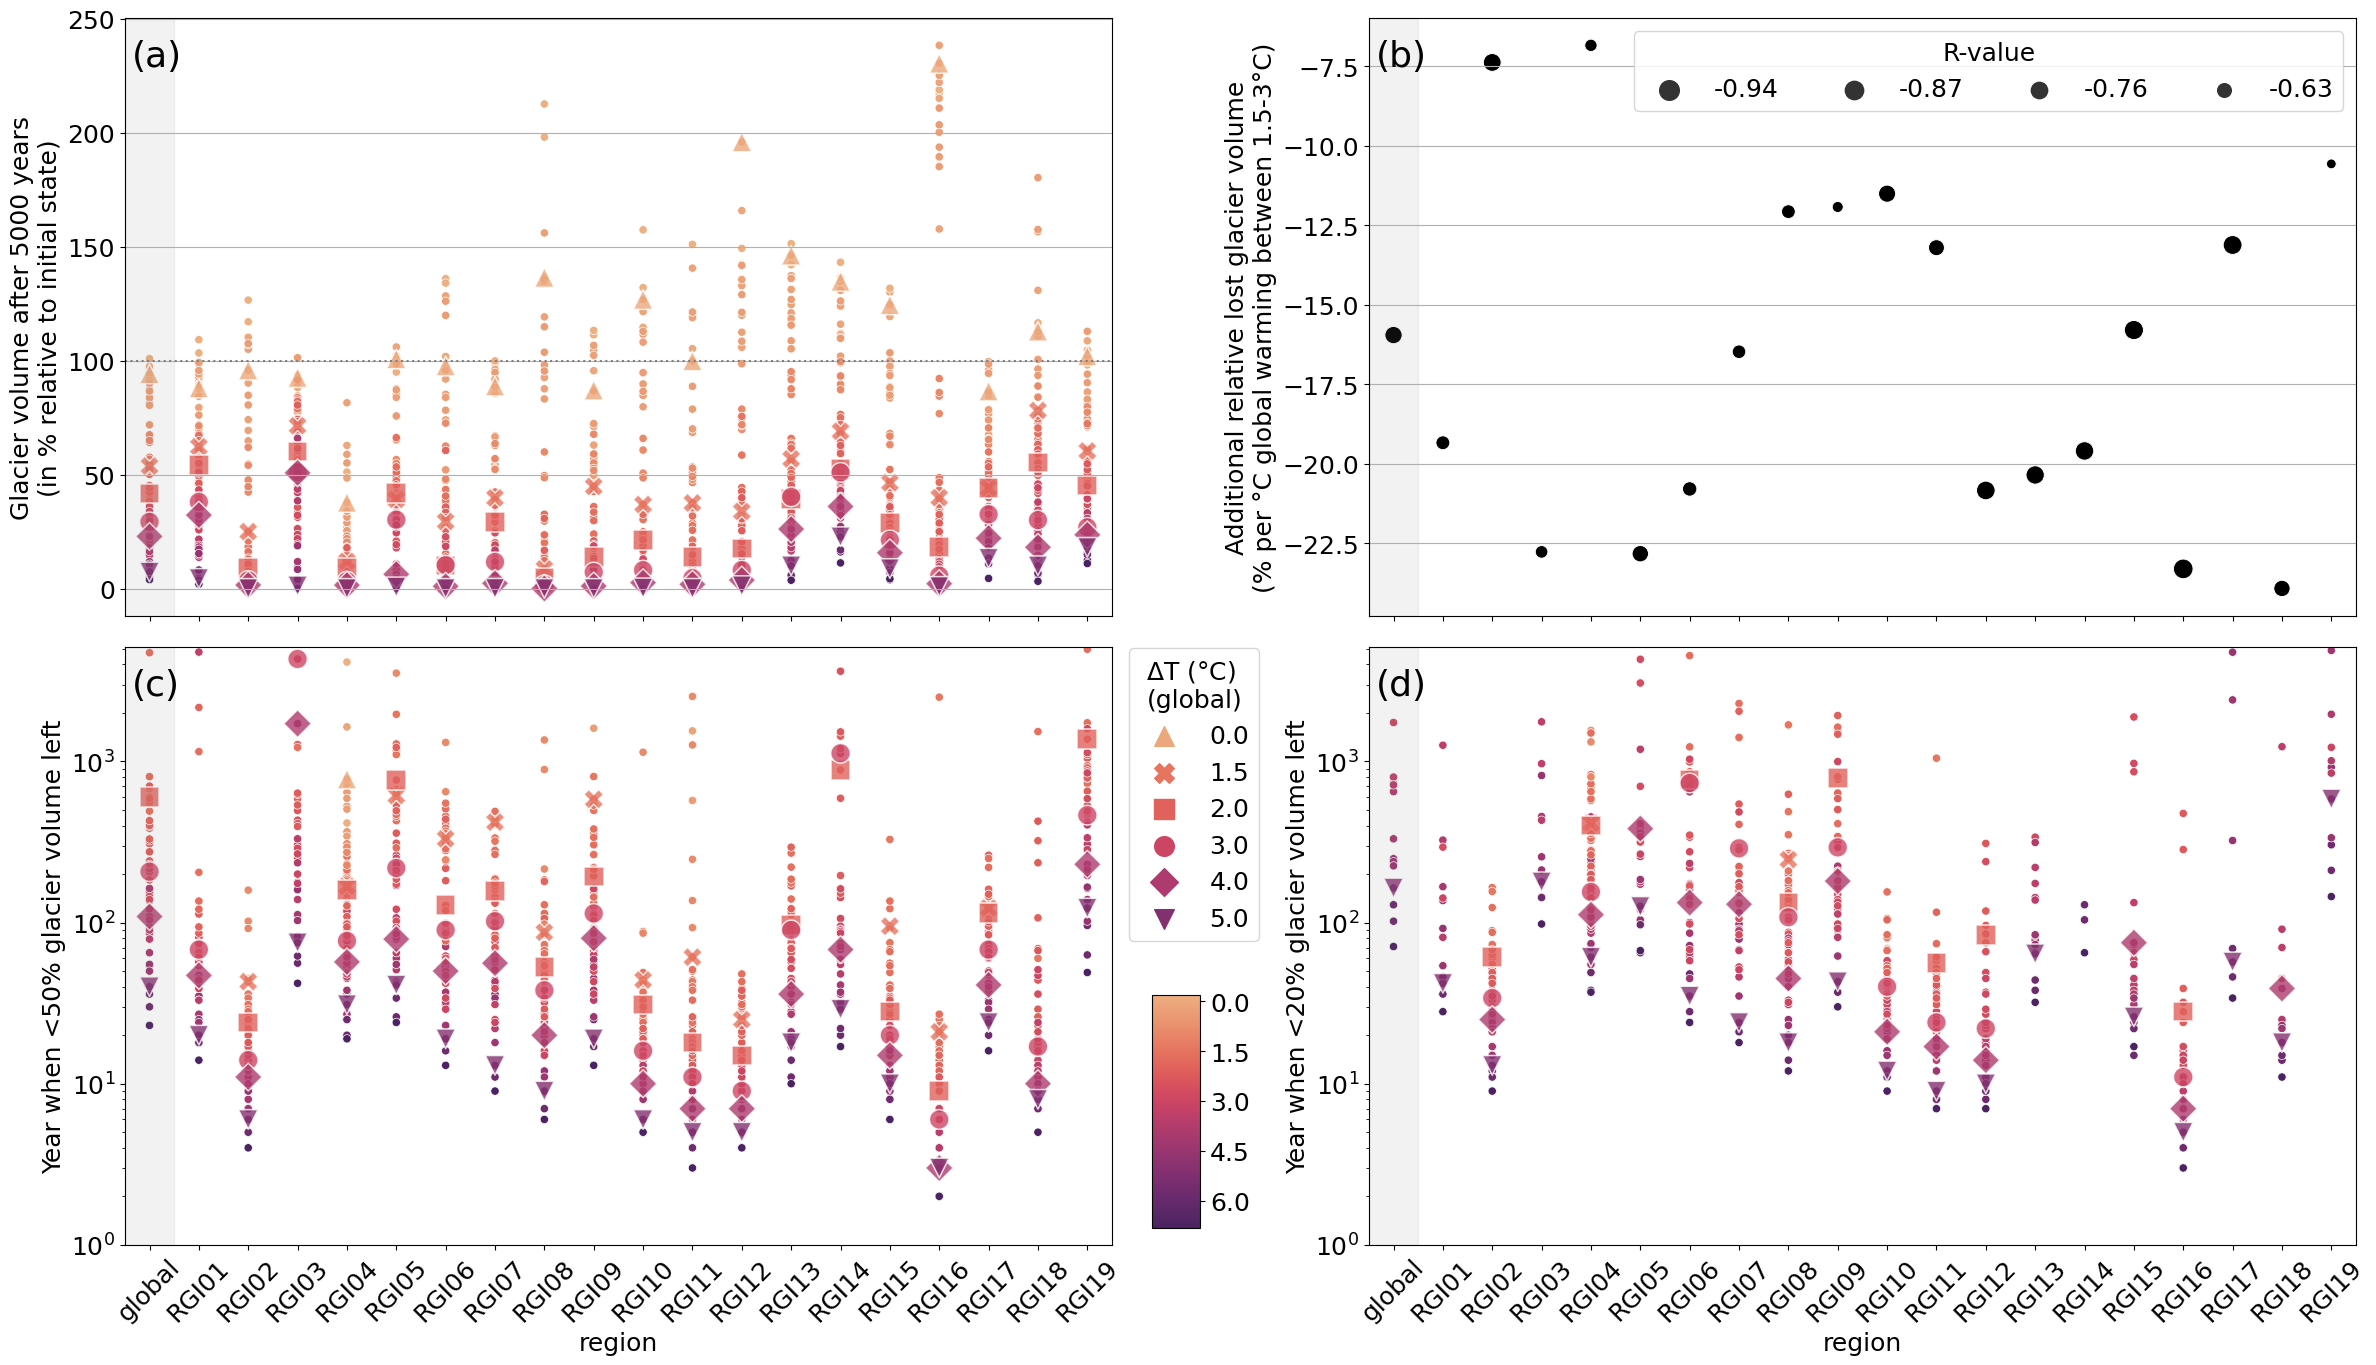

In [50]:
DATE= 'MAY12'

plt.rc('font', size=18)  

markers = ['^', 'X','s','o','D','v']

norm = plt.Normalize(vmin=pd_global_temp_exp_m['temp_ch_ipcc'].min(),
                     vmax=pd_global_temp_exp_m['temp_ch_ipcc'].max())
cmap = sns.color_palette('flare', as_cmap=True) #sns.cubehelix_palette(light=1, as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

fig, axs= plt.subplots(2,2,figsize=(24,14),sharex=True)

# first subplot
ax = axs[0][0] #lt.gca()
pd_all_models_med_vol_2000.loc[pd_all_models_med_vol_2000.volume_m3<0.1, 'volume_m3'] = 0.1
sns.scatterplot(data=pd_all_models_med_vol_2000, y='volume_m3', x='region', hue='temp_ch_ipcc',
                palette='flare', legend=False, ax=ax)
#leg = ax.legend(loc='upper left', bbox_to_anchor=(1,1), title = f'$\Delta$T (°C)\n(global)')
ax.set_ylabel(f'Glacier volume after {sim_year} years'+'\n(in % relative to initial state)')
ax.axhline(100, ls=':', color = 'grey')
ax.grid(axis='y')
ax.set_xlabel('region');

# plot specific delta T:
col_temp_l = []
exp_l = []
for temp in [0,1.5,2,3,4,5]: #,5,6]:
    exp = np.abs(pd_global_temp_exp_m-temp).sort_values(by='temp_ch_ipcc').iloc[0].name
    #sm.colorbar.norm...
    col_temp = cmap(norm(pd_global_temp_exp_m.loc[exp]['temp_ch_ipcc']))
    col_temp_l.append(col_temp)
    exp_l.append(exp)

pd_t_sel =ds_reg_models_med_vol_2000.sel(experiments=exp_l).to_dataframe().reset_index()
pd_t_sel['region']  = 'RGI' + pd_t_sel['rgi_reg']
pd_t_sel_glob =ds_glob_models_med_vol_2000.sel(experiments=exp_l).to_dataframe().reset_index()
pd_t_sel_glob['region'] = 'global'
pd_t_sel_all = pd.concat([pd_t_sel_glob, pd_t_sel])
# just to make the plot possible
pd_t_sel_all.loc[pd_t_sel_all.volume_m3 <0.1, 'volume_m3'] = 0.1
#pd_t_sel_all.loc[pd_t_sel_all.volume_m3 <0.1]['volume_m3'] = 0.1
#pd_t_sel['volume (km3)'] = pd_t_sel['volume_m3']/1e9
l_sel = sns.scatterplot(ax=ax,
             data=pd_t_sel_all,
                        markers=markers,
                        style='temp_ch_ipcc',
                        alpha = 0.8,
             y='volume_m3', x='region', hue='temp_ch_ipcc',
                        palette=sns.color_palette(col_temp_l),
             legend=False,size='temp_ch_ipcc', sizes=(200,200));
#leg = ax.legend(loc='upper left', bbox_to_anchor=(1.005,0.99),
#                title=f'$\Delta$T (°C)\n(global)',
#                markerscale=1, handleheight=0.8)

#for j,t in enumerate(leg.texts):
#    # truncate label text to 4 characters
#    if j ==1:
#        t.set_text(np.round(float(t.get_text()),1))
#    else:
#        t.set_text(np.round(float(t.get_text()),0))
# set the linewidth of each legend object
#for legobj in leg.legendHandles:
#    legobj.set_linewidth(4.0)
#    legobj.set_linestyle('--')
ax.set_xticks(pd_t_sel_all.region.unique())
ax.set_xticklabels(pd_t_sel_all.region.unique(), rotation=45)
#ax.set_yticks([5,10,20,40, 80, 160, 320],[5,10,20,40, 80, 160, 320])

#x = pd_t_sel_all.volume_m3.values
#def stratify(ax, power=2):
#    f     = lambda x: (x + 1)**(1 / power)
#    f_inv = lambda y: y**power - 1
#    ax.set_yscale('function', functions=(f, f_inv))
#stratify(ax, power=2)

#ax.set_yscale('log', base=2)
#ax.set_yticks([5,10,20,40, 80, 160, 320],[5,10,20,40, 80, 160, 320])
######## Next subplot    
ax = axs[0][1]
# ok, the pvalues are small enough anyways ...
assert np.all(pd_slope_rgi_reg.pval<1e-5)

sns.scatterplot(data=pd_slope_rgi_reg_1o5_3, x='region', y='slope', ax = ax, color= 'black',
                size='rval', sizes=(200,50), legend = 'full')
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles[::5], labels[::5],
                loc='upper right', title= 'R-value', ncol=4)
#ax.add_artist(cbar);
for j,t in enumerate(leg.texts):
    # truncate label text to 4 characters
    t.set_text(np.round(float(t.get_text()),2))
ax.grid(axis='y')
ax.set_xlabel('region')
ax.set_ylabel('Additional relative lost glacier volume\n(% per °C global warming between 1.5-3°C)')
#ax.set_ylabel('Additional relative lost glacier volume\n(% per °C global warming between 1-4 °C)')
ax.set_xticks(pd_slope_rgi_reg_1o5_3.region.unique())
ax.set_xticklabels(pd_slope_rgi_reg_1o5_3.region.unique(), rotation=45)

################### Next subplot: year where less than 50%/20% left
for ax, perc in zip(axs[1][0:2], [50,20]):
    ds_reg_models_med_vol_glob_rel = 100*ds_reg_models_med_vol.sum(dim='rgi_reg')/ds_reg_models_med_vol.sel(simulation_year=0).sum(dim='rgi_reg')
    ds_reg_models_med_vol_glob_rel = ds_reg_models_med_vol_glob_rel.assign_coords(temp_ch_ipcc = ('experiments',
                                                                          pd_global_temp_exp_m.loc[ds_reg_models_med_vol_glob_rel.experiments, # make sure thatwe use the same experiments
                                                                                                   'temp_ch_ipcc']))

    ds_reg_below_50_perc = ds_reg_models_med_vol_glob_rel.where(ds_reg_models_med_vol_glob_rel<=perc)
    ds_reg_below_50_perc.max(dim='simulation_year')
    yr_50_perc = ds_reg_below_50_perc.idxmax(dim='simulation_year')

    pd_yr_50_perc = yr_50_perc.to_dataframe(f'Year when <{perc}% glacier volume left').reset_index()
    pd_yr_50_perc['region'] = 'global' 

    for rgi_reg in rgi_regs:
        ds_reg_models_med_vol_sel_rel = 100*ds_reg_models_med_vol.sel(rgi_reg=rgi_reg)/ds_reg_models_med_vol.sel(simulation_year=0).sel(rgi_reg=rgi_reg)
        ds_reg_models_med_vol_sel_rel = ds_reg_models_med_vol_sel_rel.assign_coords(temp_ch_ipcc = ('experiments',
                                                                              pd_global_temp_exp_m.loc[ds_reg_models_med_vol_sel_rel.experiments, # make sure thatwe use the same experiments
                                                                                                       'temp_ch_ipcc']))

        ds_reg_below_50_perc_sel = ds_reg_models_med_vol_sel_rel.where(ds_reg_models_med_vol_sel_rel<=perc)
        ds_reg_below_50_perc_sel.max(dim='simulation_year')
        yr_50_perc_sel = ds_reg_below_50_perc_sel.idxmax(dim='simulation_year')

        pd_yr_50_perc_reg = yr_50_perc_sel.to_dataframe(f'Year when <{perc}% glacier volume left').reset_index()
        pd_yr_50_perc_reg['region'] = f'RGI{rgi_reg}'
        pd_yr_50_perc = pd.concat([pd_yr_50_perc,pd_yr_50_perc_reg])

    pd_yr_50_perc=pd_yr_50_perc.drop(columns='rgi_reg')
    #pd_yr_50_perc = pd_yr_50_perc.dropna()

    sns.scatterplot(ax=ax,
                    hue='temp_ch_ipcc',
                    y=f'Year when <{perc}% glacier volume left',
                    x='region',
                    palette='flare',
                    data=pd_yr_50_perc, legend=False)

    # plot specific delta T:
    ds_sel = pd_yr_50_perc.groupby(['gcm','period_scenario','region']).mean().to_xarray().stack(experiments=['gcm','period_scenario'])
    pd_yr_50_perc_sel = ds_sel.sel(experiments=exp_l).to_dataframe().reset_index().dropna()
    
    if np.all(pd_yr_50_perc_sel.temp_ch_ipcc >=0.5):
        # in no region that amount is lost when having 0°C global warming
        col_temp_l_sel = col_temp_l[1:].copy()
        markers_sel = markers[1:].copy()
    else:
        col_temp_l_sel = col_temp_l.copy()
        markers_sel = markers.copy()
        
    if perc == 50:
        legend_opt = 'auto'
    else:
        legend_opt = False
    sns.scatterplot(ax=ax,
                    hue='temp_ch_ipcc',
                    y=f'Year when <{perc}% glacier volume left',
                    x='region',
                    data=pd_yr_50_perc_sel,
                    markers=markers_sel,
                    style='temp_ch_ipcc',
                    palette=sns.color_palette(col_temp_l_sel),
                    alpha = 0.8,
                 legend=legend_opt,size='temp_ch_ipcc', sizes=(200,200));
    if perc == 50:
        leg = ax.legend(loc='upper left', bbox_to_anchor=(1.005,1.02),
                        title=f'$\Delta$T (°C)\n(global)',
                        markerscale=1, handleheight=0.8)
        for j,t in enumerate(leg.texts):
        #    # truncate label text to 4 characters
            if j ==1:
                t.set_text(np.round(float(t.get_text()),1))
            else:
                t.set_text(np.round(float(t.get_text()),0))
                
                
        ## get colormap 
        add_cmap = True
        if add_cmap:
            cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.02, ax.get_position().height / 2.1])
            cbar = ax.figure.colorbar(sm, cax=cax)
            cbar.ax.invert_yaxis()
            cbar.set_ticks([0,1.5,3.0,4.5,6.0])
    ax.set_ylim([1,5100])
    ax.set_yscale('log')
    ax.set_xticks(pd_yr_50_perc.region.unique())
    ax.set_xticklabels(pd_yr_50_perc.region.unique(), rotation=45)
    
plt.tight_layout() 
num_text_x = 0.007
for j,axi in enumerate([axs[0][0],axs[0][1], axs[1][0], axs[1][1]]):
    #if j <2:
    num_text_y = 0.92
    #else:
    #    num_text_y = 0.87
    axi.text(num_text_x, num_text_y,
             num_dict[j], fontsize=26, transform=axi.transAxes)
    axi.axvspan(-0.5,0.5,color='grey', alpha = 0.1)
    axi.set_xlim([-0.5,19.5])
plt.savefig(f'figures/2_condensed_rgi_region_analysis_{DATE}_{sim_year}yr.png')

### compare slopes
- just globally for the moment ...

<AxesSubplot:ylabel='temp_ch_ipcc'>

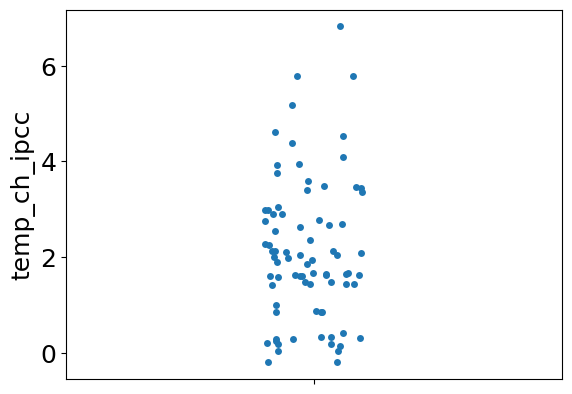

In [359]:
sns.stripplot(pd_sel['temp_ch_ipcc'])

In [364]:
r0

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75])

In [382]:
# get the % lost per °C (here from 1.5 - 3°C)
region = 'global'
pd_sel = pd_all_models_med_vol_2000.loc[pd_all_models_med_vol_2000.region==region]

slope_rgi_dict = {}
pd_slope_diff_ranges = pd.DataFrame(index=np.arange(0,20))
intercept_l = []
slope_l = []
rval_l = []
pval_l = []
stderr_l = []
region_l = []

r0_r1_l = []
n_l = []
for r0,r1 in zip(np.arange(0,5,0.25),np.arange(1,6,0.25)):
    pd_sel_r0_r1 = pd_sel.loc[(pd_sel.temp_ch_ipcc>=r0) & (pd_sel.temp_ch_ipcc<=r1)]
    n = len(pd_sel_r0_r1)
    slope, intercept, rval, pval, stderr = scipy.stats.linregress(pd_sel_r0_r1['temp_ch_ipcc'].values, pd_sel_r0_r1['volume_m3'])
    slope_l.append(slope)
    intercept_l.append(intercept)
    stderr_l.append(stderr)
    rval_l.append(rval)
    pval_l.append(pval)
    r0_r1_l.append(f'{r0}-{r1}°C: n={n}')
    n_l.append(n)
pd_slope_diff_ranges['slope'] = slope_l
pd_slope_diff_ranges['intercept'] = intercept_l
pd_slope_diff_ranges['stderr'] = stderr_l
pd_slope_diff_ranges['pval'] = pval_l
pd_slope_diff_ranges['rval'] = rval_l
pd_slope_diff_ranges['region'] = region
pd_slope_diff_ranges['temp_range'] = r0_r1_l
pd_slope_diff_ranges['n'] = n_l

pd_slope_diff_ranges_sel=pd_slope_diff_ranges.loc[pd_slope_diff_ranges.n>=6]


/home/users/lschuster/.local/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:181: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/users/lschuster/.local/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:195: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/users/lschuster/.local/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:198: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


slope   intercept    stderr          pval      rval  region  \
0 -32.717116   93.926296  3.015333  8.724205e-09 -0.938272  global   
1 -32.412574   93.942537  4.381795  4.116047e-05 -0.926688  global   
2 -18.851157   82.104536  2.029146  6.581039e-06 -0.951614  global   
3 -25.539298   88.775481  3.606131  7.258732e-07 -0.845533  global   
4 -33.049818  100.947839  6.100841  2.654316e-05 -0.771171  global   
5 -27.149269   91.726603  3.896940  1.732140e-07 -0.801597  global   
6 -22.356612   82.335854  4.115155  1.395272e-05 -0.742648  global   
7 -16.999949   71.344181  4.230697  8.912848e-04 -0.697941  global   
8 -12.444610   61.616836  3.505263  2.286596e-03 -0.641754  global   

          temp_range   n  
0    0.0-1.0°C: n=18  18  
1  0.25-1.25°C: n=11  11  
2    0.5-1.5°C: n=11  11  
3  0.75-1.75°C: n=22  22  
4    1.0-2.0°C: n=22  22  
5  1.25-2.25°C: n=29  29  
6    1.5-2.5°C: n=26  26  
7  1.75-2.75°C: n=19  19  
8    2.0-3.0°C: n=20  20

Text(0.5, 0, 'Additional relative lost glacier volume\n(% per °C global warming in given range)')

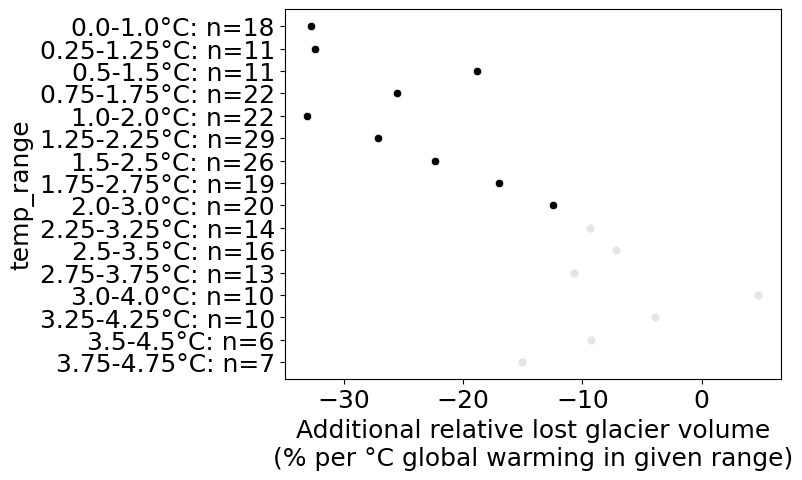

In [397]:
sns.scatterplot(data=pd_slope_diff_ranges_sel, y='temp_range', x='slope',color= 'grey', alpha = 0.2)
       #         size='rval', sizes=(200,20)) #, legend = 'full')

sns.scatterplot(data=pd_slope_diff_ranges_sel.loc[pd_slope_diff_ranges_sel.pval<0.05], y='temp_range', x='slope',color= 'black')
                #size='pval',
                #sizes=(200,50)) 
plt.xlabel('Additional relative lost glacier volume\n(% per °C global warming in given range)')


### compare "response time"
three options where experiments and model simulations need to be classified in: 
- are "shrinking" 
- are "growing" 
- stay around the same (even if there is a spinup)

In [327]:
fill_option = 'repeat_last_20yrs'

In [328]:
DATE = 'apr04'

In [329]:
ds_reg_models_extend = xr.open_dataset(f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc')
pd_global_temp_exp_m = get_glob_temp_exp(region='global')



plt.rc('font', size=18)  

markers = ['^', 'X','s','o','D','v']

norm = plt.Normalize(vmin=pd_global_temp_exp_m['temp_ch_ipcc'].min(),
                     vmax=pd_global_temp_exp_m['temp_ch_ipcc'].max())
cmap = sns.color_palette('flare', as_cmap=True) #sns.cubehelix_palette(light=1, as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# plot specific delta T:
col_temp_l = []
exp_l = []
for temp in [0,1.5,2,3,4,5]: #,5,6]:
    exp = np.abs(pd_global_temp_exp_m-temp).sort_values(by='temp_ch_ipcc').iloc[0].name
    #sm.colorbar.norm...
    col_temp = cmap(norm(pd_global_temp_exp_m.loc[exp]['temp_ch_ipcc']))
    col_temp_l.append(col_temp)
    exp_l.append(exp)

In [55]:
rgi_reg = '06'
eq_med_vol_reg = ds_reg_models_med_vol_all.isel(simulation_year=np.arange(-20,0,1)).sel(rgi_reg=rgi_reg).mean(dim='simulation_year')
begin_med_vol_reg = ds_reg_models_med_vol_all.isel(simulation_year=0).sel(rgi_reg=rgi_reg)

ds_reg_models_med_vol_sel_rel = np.abs(100*(begin_med_vol_reg-ds_reg_models_med_vol_all.sel(rgi_reg=rgi_reg))/(begin_med_vol_reg-eq_med_vol_reg)) # can be positive and negative 
ds_reg_models_med_vol_sel_rel = ds_reg_models_med_vol_sel_rel.assign_coords(temp_ch_ipcc = ('experiments',
                                                                      pd_global_temp_exp_m.loc[ds_reg_models_med_vol_sel_rel.experiments, # make sure thatwe use the same experiments
                                                                                               'temp_ch_ipcc']))

ds_reg_below_perc_sel = ds_reg_models_med_vol_sel_rel.where((ds_reg_models_med_vol_sel_rel<=perc) | (ds_reg_models_med_vol_sel_rel>=100+perc)) #ds_reg_models_med_vol_sel_rel.where(ds_reg_models_med_vol_sel_rel<=perc)
yr_perc_sel = ds_reg_below_perc_sel.idxmax(dim='simulation_year')

NameError: name 'ds_reg_models_med_vol_all' is not defined

In [56]:
plt.plot(ds_reg_models_med_vol_all.sel(experiments=yr_perc_sel.idxmax()).sel(rgi_reg=rgi_reg))

NameError: name 'ds_reg_models_med_vol_all' is not defined

/tmp/ipykernel_3683469/2150098092.py:107: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(pd_yr_perc_resp_time.region.unique(), rotation=45)
/tmp/ipykernel_3683469/2150098092.py:107: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(pd_yr_perc_resp_time.region.unique(), rotation=45)
/tmp/ipykernel_3683469/2150098092.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


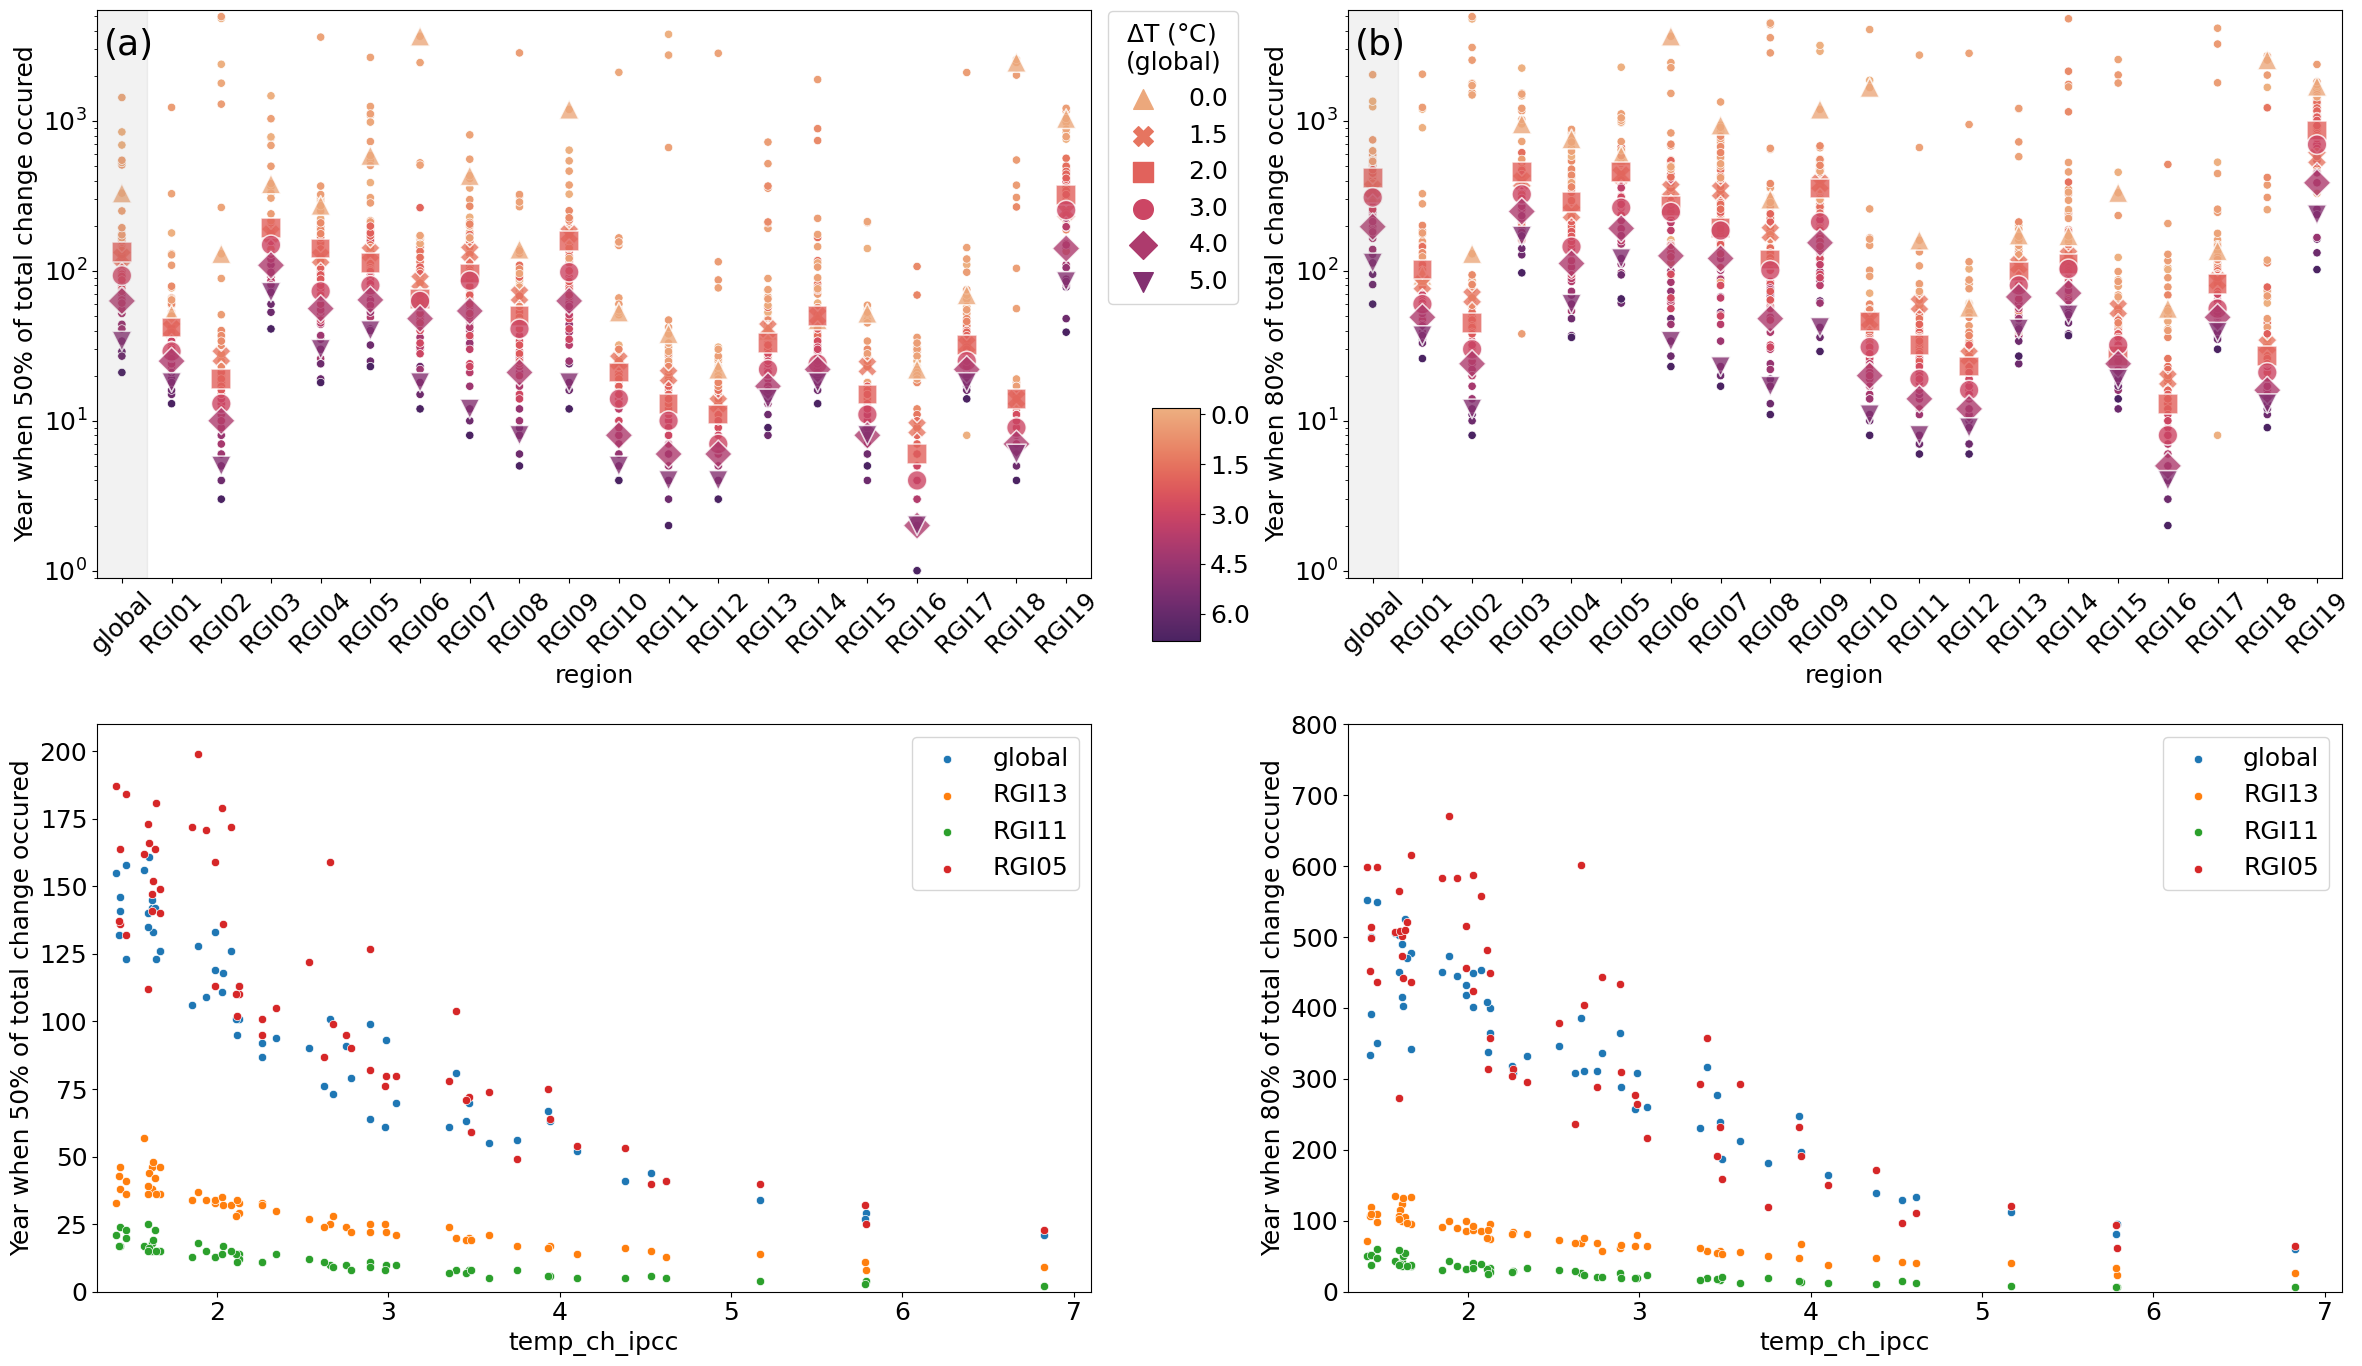

In [59]:
fig, axss= plt.subplots(2,2,figsize=(24,14))

# first subplot
axs = axss[0]
jj=0
for ax, perc in zip(axs[0:2], [50,80]):

    ds_reg_models_vol_all = ds_reg_models_extend.volume_m3 # .sel(simulation_year=slice(0,2000)) # need to do the interpolation first !!!!
    # Let's take the median/iqr estimate from all glacier models for every RGI region and then do the sum:
    ds_reg_models_vol_all = ds_reg_models_vol_all.stack(experiments=['gcm','period_scenario'])
    ds_reg_models_med_vol_all = ds_reg_models_vol_all.median(dim='model_author')
    
    eq_med_vol = ds_reg_models_med_vol_all.isel(simulation_year=np.arange(-20,0,1)).sum(dim='rgi_reg').mean(dim='simulation_year')
    begin_med_vol = ds_reg_models_med_vol_all.isel(simulation_year=0).sum(dim='rgi_reg')

    
    ds_reg_models_med_vol_glob_resp_time =   np.abs(100*(begin_med_vol-ds_reg_models_med_vol_all.sum(dim='rgi_reg')) / (begin_med_vol- eq_med_vol)) # can be positive and negative 
    ds_reg_models_med_vol_glob_resp_time = ds_reg_models_med_vol_glob_resp_time.assign_coords(temp_ch_ipcc = ('experiments',
                                                                          pd_global_temp_exp_m.loc[ds_reg_models_med_vol_glob_resp_time.experiments, # make sure thatwe use the same experiments
                                                                                                   'temp_ch_ipcc']))

    ds_reg_models_med_vol_glob_resp_time_perc = ds_reg_models_med_vol_glob_resp_time.where((ds_reg_models_med_vol_glob_resp_time<=perc) | (ds_reg_models_med_vol_glob_resp_time>=100+perc)) #ds_reg_models_med_vol_glob_resp_time.where(ds_reg_models_med_vol_glob_resp_time<=perc)
    #ds_reg_below_50_perc.max(dim='simulation_year')
    yr_perc = ds_reg_models_med_vol_glob_resp_time_perc.idxmax(dim='simulation_year')

    pd_yr_perc_resp_time = yr_perc.to_dataframe(f'Year when {perc}% of total change occured').reset_index()
    pd_yr_perc_resp_time['region'] = 'global' 
    
    for rgi_reg in ds_reg_models_extend.rgi_reg.values:
        eq_med_vol_reg = ds_reg_models_med_vol_all.isel(simulation_year=np.arange(-20,0,1)).sel(rgi_reg=rgi_reg).mean(dim='simulation_year')
        begin_med_vol_reg = ds_reg_models_med_vol_all.isel(simulation_year=0).sel(rgi_reg=rgi_reg)

        ds_reg_models_med_vol_sel_rel = np.abs(100*(begin_med_vol_reg-ds_reg_models_med_vol_all.sel(rgi_reg=rgi_reg))/(begin_med_vol_reg-eq_med_vol_reg)) # can be positive and negative 
        ds_reg_models_med_vol_sel_rel = ds_reg_models_med_vol_sel_rel.assign_coords(temp_ch_ipcc = ('experiments',
                                                                              pd_global_temp_exp_m.loc[ds_reg_models_med_vol_sel_rel.experiments, # make sure thatwe use the same experiments
                                                                                                       'temp_ch_ipcc']))

        ds_reg_below_perc_sel = ds_reg_models_med_vol_sel_rel.where((ds_reg_models_med_vol_sel_rel<=perc) | (ds_reg_models_med_vol_sel_rel>=100+perc)) #ds_reg_models_med_vol_sel_rel.where(ds_reg_models_med_vol_sel_rel<=perc)
        yr_perc_sel = ds_reg_below_perc_sel.idxmax(dim='simulation_year')

        pd_yr_perc_resp_time_reg = yr_perc_sel.to_dataframe(f'Year when {perc}% of total change occured').reset_index()
        pd_yr_perc_resp_time_reg['region'] = f'RGI{rgi_reg}'
        pd_yr_perc_resp_time = pd.concat([pd_yr_perc_resp_time,pd_yr_perc_resp_time_reg])

    pd_yr_perc_resp_time=pd_yr_perc_resp_time.drop(columns='rgi_reg')
    
    sns.scatterplot(ax=ax,
                    hue='temp_ch_ipcc',
                    y=f'Year when {perc}% of total change occured',
                    x='region',
                    palette='flare',
                    data=pd_yr_perc_resp_time, legend=False)
    

    #axss[1][jj].set_ylim([0.9,2000])
    
    
    # plot specific delta T:
    ds_sel = pd_yr_perc_resp_time.groupby(['gcm','period_scenario','region']).mean().to_xarray().stack(experiments=['gcm','period_scenario'])
    pd_yr_perc_resp_time_sel = ds_sel.sel(experiments=exp_l).to_dataframe().reset_index().dropna()
    
    if np.all(pd_yr_perc_resp_time_sel.temp_ch_ipcc >=0.5):
        # in no region that amount is lost when having 0°C global warming
        col_temp_l_sel = col_temp_l[1:].copy()
        markers_sel = markers[1:].copy()
    else:
        col_temp_l_sel = col_temp_l.copy()
        markers_sel = markers.copy()
        
    if perc == 50:
        legend_opt = 'auto'
    else:
        legend_opt = False
    sns.scatterplot(ax=ax,
                    hue='temp_ch_ipcc',
                    y=f'Year when {perc}% of total change occured',
                    x='region',
                    data=pd_yr_perc_resp_time_sel,
                    markers=markers_sel,
                    style='temp_ch_ipcc',
                    palette=sns.color_palette(col_temp_l_sel),
                    alpha = 0.8,
                 legend=legend_opt,size='temp_ch_ipcc', sizes=(200,200));
    
    if perc == 50:
        leg = ax.legend(loc='upper left', bbox_to_anchor=(1.005,1.02),
                        title=f'$\Delta$T (°C)\n(global)',
                        markerscale=1, handleheight=0.8)
        for j,t in enumerate(leg.texts):
        #    # truncate label text to 4 characters
            if j ==1:
                t.set_text(np.round(float(t.get_text()),1))
            else:
                t.set_text(np.round(float(t.get_text()),0))
                
                
        ## get colormap 
        add_cmap = True
        if add_cmap:
            cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.02, ax.get_position().height / 2.1])
            cbar = ax.figure.colorbar(sm, cax=cax)
            cbar.ax.invert_yaxis()
            cbar.set_ticks([0,1.5,3.0,4.5,6.0])

    ax.set_yscale('log')
    
    ax.set_xticklabels(pd_yr_perc_resp_time.region.unique(), rotation=45)
    ax.set_ylim([0.9,5500])
    
    
    sns.scatterplot(x='temp_ch_ipcc',
          y=f'Year when {perc}% of total change occured',
          data=pd_yr_perc_resp_time.loc[pd_yr_perc_resp_time.region == 'global'], ax=axss[1][jj], label='global')
    sns.scatterplot(x='temp_ch_ipcc',
          y=f'Year when {perc}% of total change occured',
          data=pd_yr_perc_resp_time.loc[pd_yr_perc_resp_time.region == 'RGI13'], ax=axss[1][jj], label='RGI13')
    sns.scatterplot(x='temp_ch_ipcc',
          y=f'Year when {perc}% of total change occured',
          data=pd_yr_perc_resp_time.loc[pd_yr_perc_resp_time.region == 'RGI11'], ax=axss[1][jj], label='RGI11')
    sns.scatterplot(x='temp_ch_ipcc',
          y=f'Year when {perc}% of total change occured',
          data=pd_yr_perc_resp_time.loc[pd_yr_perc_resp_time.region == 'RGI05'], ax=axss[1][jj], label='RGI05')
    if perc == 50:
        axss[1][jj].set_ylim([0,210])
    else:
        axss[1][jj].set_ylim([0,800])
    axss[1][jj].set_xlim([1.3,7.1])

    jj+=1
    
    
num_text_x = 0.007
for j,axi in enumerate([axs[0],axs[1]]): #0][1], axs[1][0], axs[1][1]]):
    #if j <2:
    num_text_y = 0.92
    #else:
    #    num_text_y = 0.87
    axi.text(num_text_x, num_text_y,
             num_dict[j], fontsize=26, transform=axi.transAxes)
    axi.axvspan(-0.5,0.5,color='grey', alpha = 0.1)
    axi.set_xlim([-0.5,19.5])
    
    
plt.tight_layout()
plt.savefig(f'figures/2_resp_time_rgi_region_analysis.png')

- spinup effect that creates the large spread at the beginning probably ... 
- need to clarify what is growing
- at the moment assume equilibrium after 5000 years and we take the average over the last 20 years

## For every glacier model separately:

In [343]:
def resp_time_estimate(model_author='OGGM_v16', perc_change_l=[-80,-50,+50],
                       rgi_reg='11', min_perc_change=20):
    # computes "resp time" estimate for all 80 experiments of a given model_author and rgi_reg 
    # perc_change : -50 (gives estimates of how fast 50% of total volume change occurs)
    
    if rgi_reg == 'All':
        if model_author in global_models:
            ds_reg_models_vol_all = ds_reg_models_extend.volume_m3.sum(dim='rgi_reg')
        else:
            raise Exception("not a global model!!!")
    
    else:
        ds_reg_models_vol_all = ds_reg_models_extend.volume_m3.sel(rgi_reg=rgi_reg) # .sel(simulation_year=slice(0,2000)) # need to do the interpolation first !!!!

    ds_reg_models_vol_all = ds_reg_models_vol_all.stack(experiments=['gcm','period_scenario'])
    ds_reg_models_vol_all = ds_reg_models_vol_all.assign_coords(temp_ch_ipcc = ('experiments',
                                                                      pd_global_temp_exp_m.loc[ds_reg_models_vol_all.experiments, # make sure that we use the same experiments
                                                                                               'temp_ch_ipcc']))
    ds_reg_models_sel_vol_all = ds_reg_models_vol_all.sel(model_author=model_author)
    # 
    v_eq = ds_reg_models_sel_vol_all.sel(simulation_year=slice(4981,5000)).mean(dim='simulation_year')
    v0 = ds_reg_models_sel_vol_all.isel(simulation_year=0)
    
    pd_category_resp_time = pd.DataFrame(index=ds_reg_models_vol_all.experiments)
    if rgi_reg == 'All':
        pd_category_resp_time['rgi_reg'] = f'All'
    else:
        pd_category_resp_time['rgi_reg'] = f'RGI{rgi_reg}'
    pd_category_resp_time['model_author'] = model_author
    pd_category_resp_time['min_perc_change'] = min_perc_change
    pd_category_resp_time.loc[ds_reg_models_vol_all.experiments, 'temp_ch_ipcc']  = ds_reg_models_vol_all.temp_ch_ipcc.values
    # did it grow, shrink or stay the same???
    pd_category_resp_time['category'] = r'similar to V$_{0}$'
    grow_exps = exp_category.where(v_eq/v0 >=1+min_perc_change/100, drop=True).experiments.values
    pd_category_resp_time.loc[grow_exps, 'category'] = 'grow'
    grow_exps = exp_category.where(v_eq/v0 <=1-min_perc_change/100, drop=True).experiments.values
    pd_category_resp_time.loc[grow_exps, 'category'] = 'shrink'
    
    for perc_change in perc_change_l:
        # response time computation
        # V(resp_t) = -perc/100 * (V_eq-v0)+v0)
        v_resp_t = -perc_change/100*(v_eq-v0)+v0
        v_roll = ds_reg_models_sel_vol_all.rolling(simulation_year=5, center=True).mean()
        resp_t = ds_reg_models_sel_vol_all.where(v_roll<=v_resp_t).idxmax(dim='simulation_year')
        if perc_change<0:
            # if we look at how much it shrinks it should at least shrink by min_perc_change to estimate a "response time"
            resp_t = resp_t.where(v_eq/v0 <=1-min_perc_change/100, np.NaN)
        else:
            # if we look at how much it grows it should at least grow by min_perc_change to estimate a "response time"
            resp_t = resp_t.where(v_eq/v0 >=1+min_perc_change/100, np.NaN)
        if perc_change>0:
            perc_change_i = f'+{perc_change}'
        else:
            perc_change_i = perc_change
        pd_category_resp_time.loc[resp_t.experiments,f'resp_time_{perc_change_i}%'] = resp_t.values
    
    return pd_category_resp_time

In [346]:
# test
for model_author in ['OGGM_v16', 'OGGM-VAS', 'Compagno']:
    for rgi_reg in rgi_regs:
        pd_test = resp_time_estimate(model_author=model_author, perc_change_l=[-50],
                           rgi_reg=rgi_reg, min_perc_change=20)
        pd_test = pd_test.dropna()

        for j,ind in enumerate(pd_test.index):
            ds_test = ds_reg_models_extend.volume_m3.sel(model_author=model_author, rgi_reg=rgi_reg).stack(experiments=['gcm','period_scenario']).sel(experiments=pd_test.index[j])
            ds_test = ds_test.rolling(simulation_year=5, center=True).mean()
            vol_change_at_resp_time_yr = ds_test[0]-ds_test.sel(simulation_year = pd_test.iloc[j]['resp_time_-50%'])
            np.testing.assert_allclose(vol_change_at_resp_time_yr, 0.5*(ds_test[0]-ds_test[-1]), rtol=0.003)

In [348]:
pd_test = resp_time_estimate(model_author='James', perc_change_l=[-50],
                           rgi_reg='06', min_perc_change=20)

In [352]:
pd_test.dropna().min()

rgi_reg               RGI06
model_author          James
min_perc_change          20
temp_ch_ipcc       0.841467
category             shrink
resp_time_-50%          8.0
dtype: object

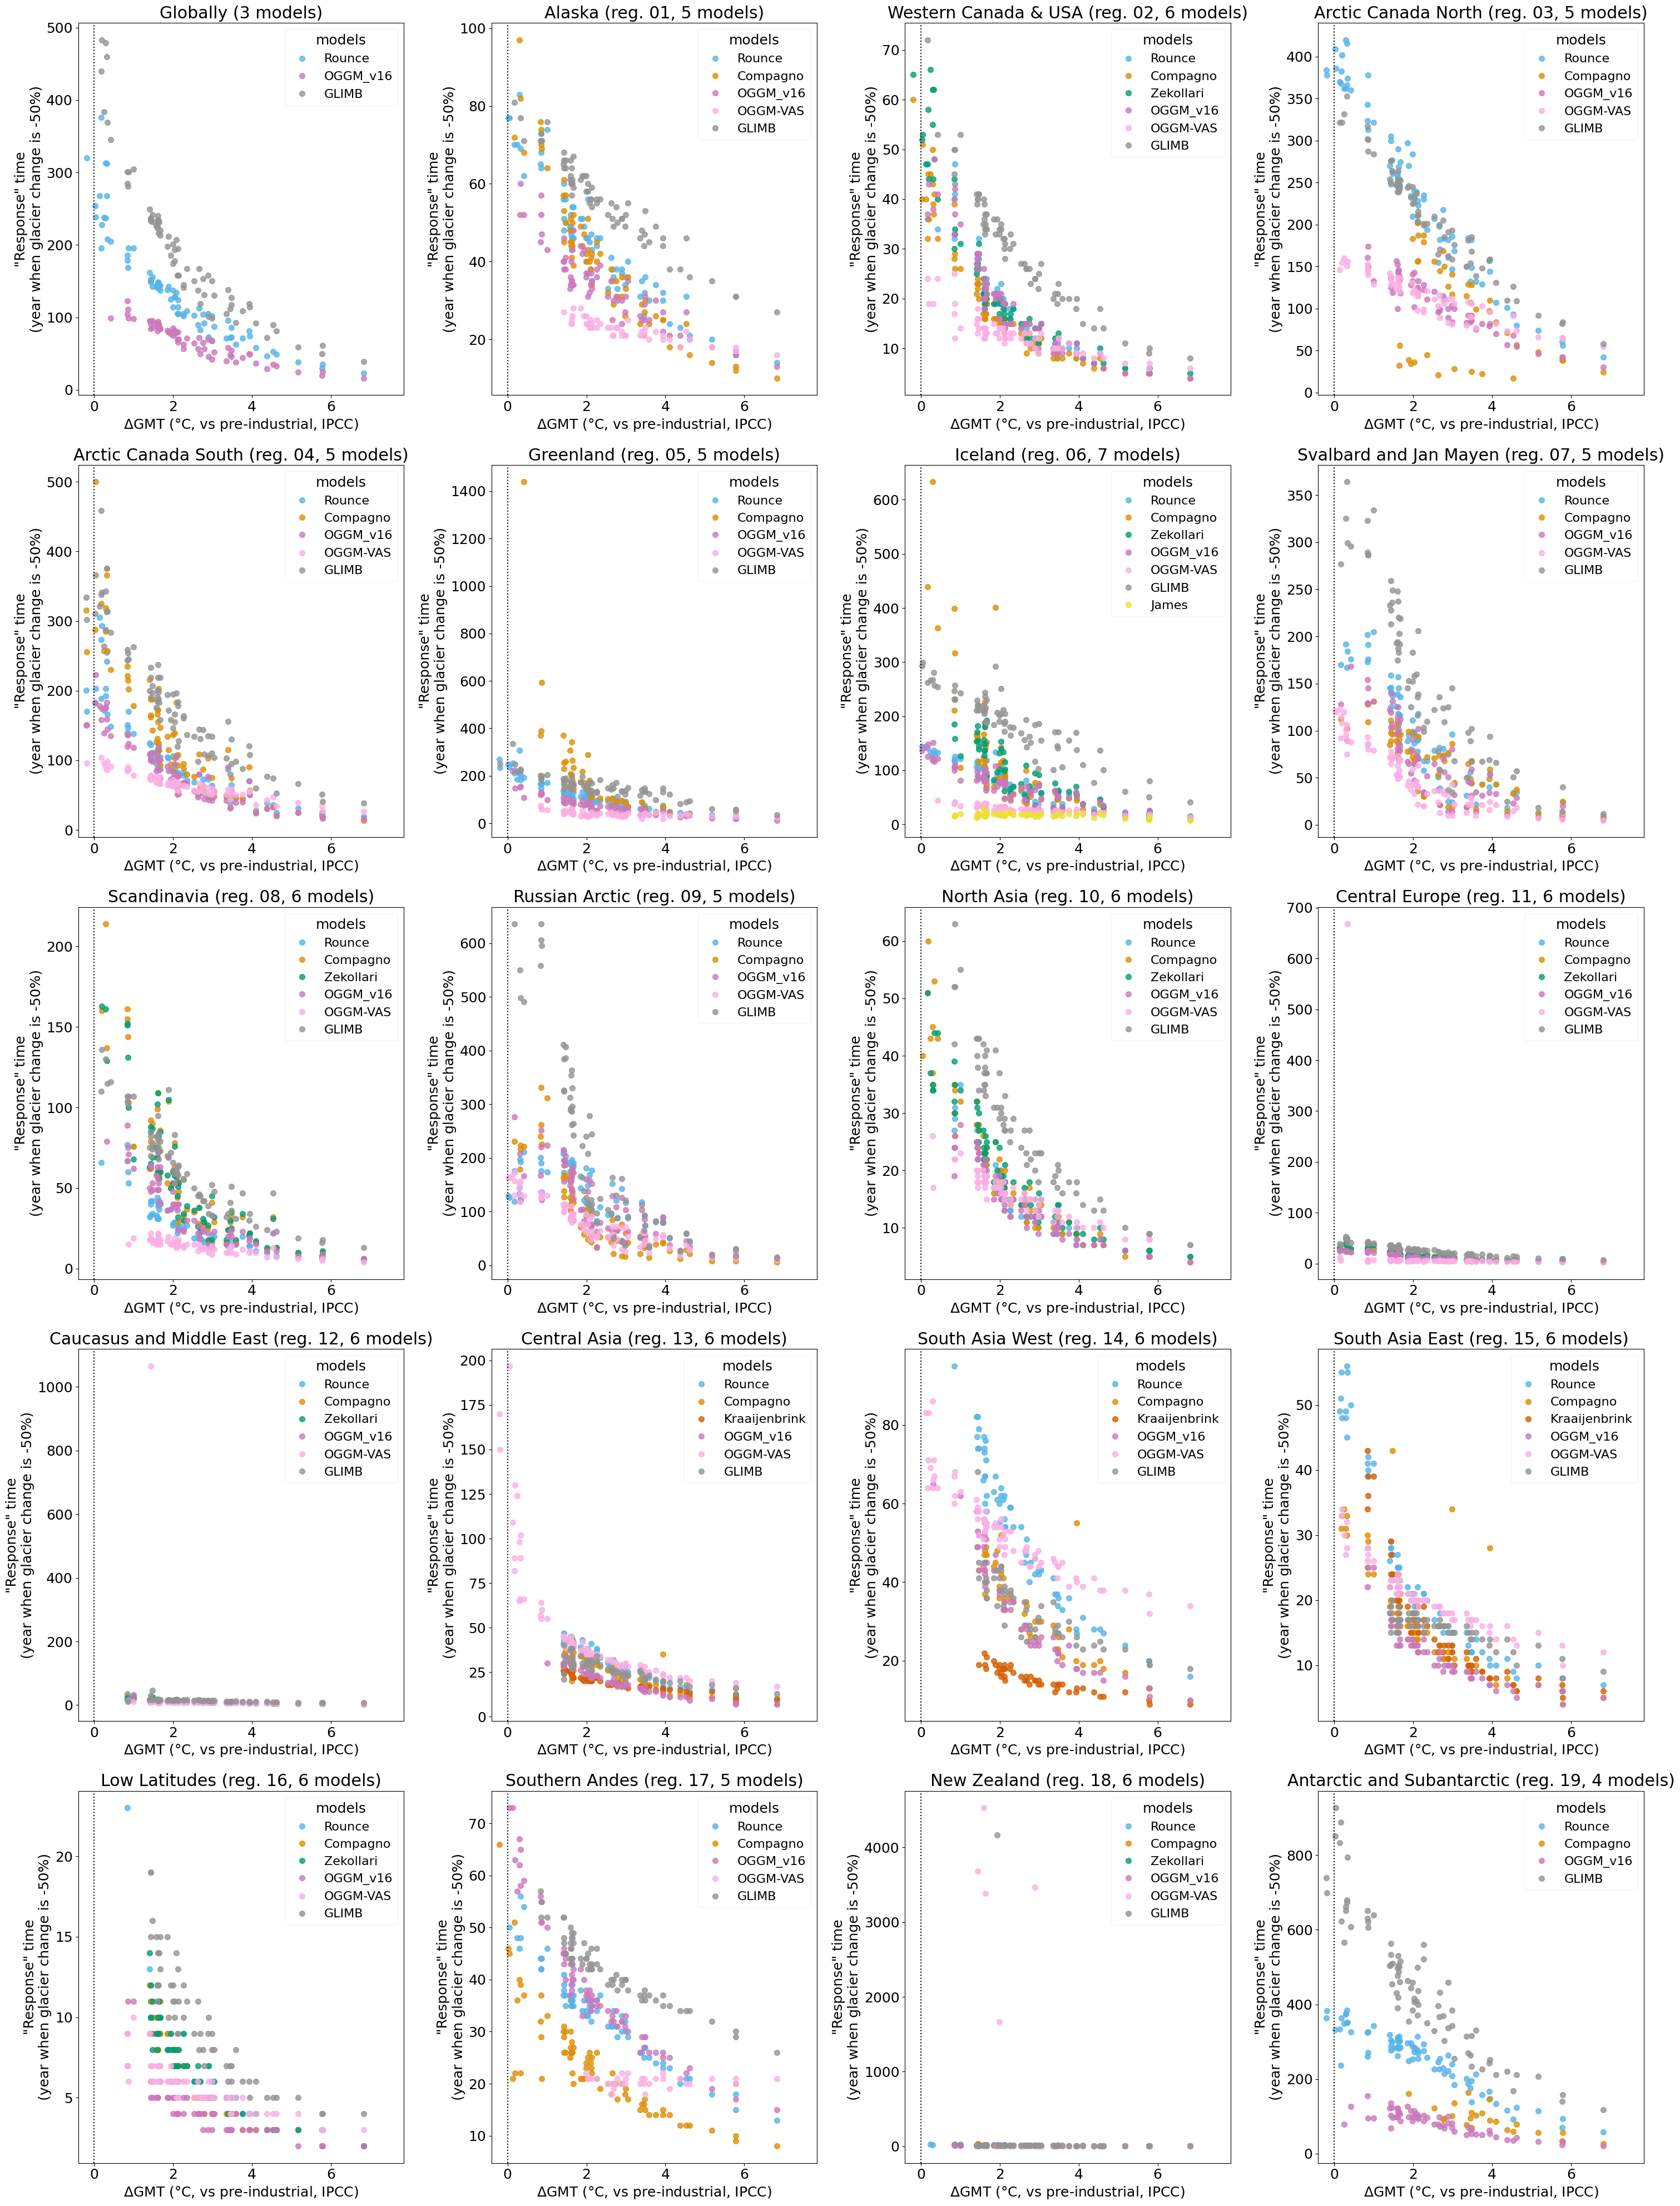

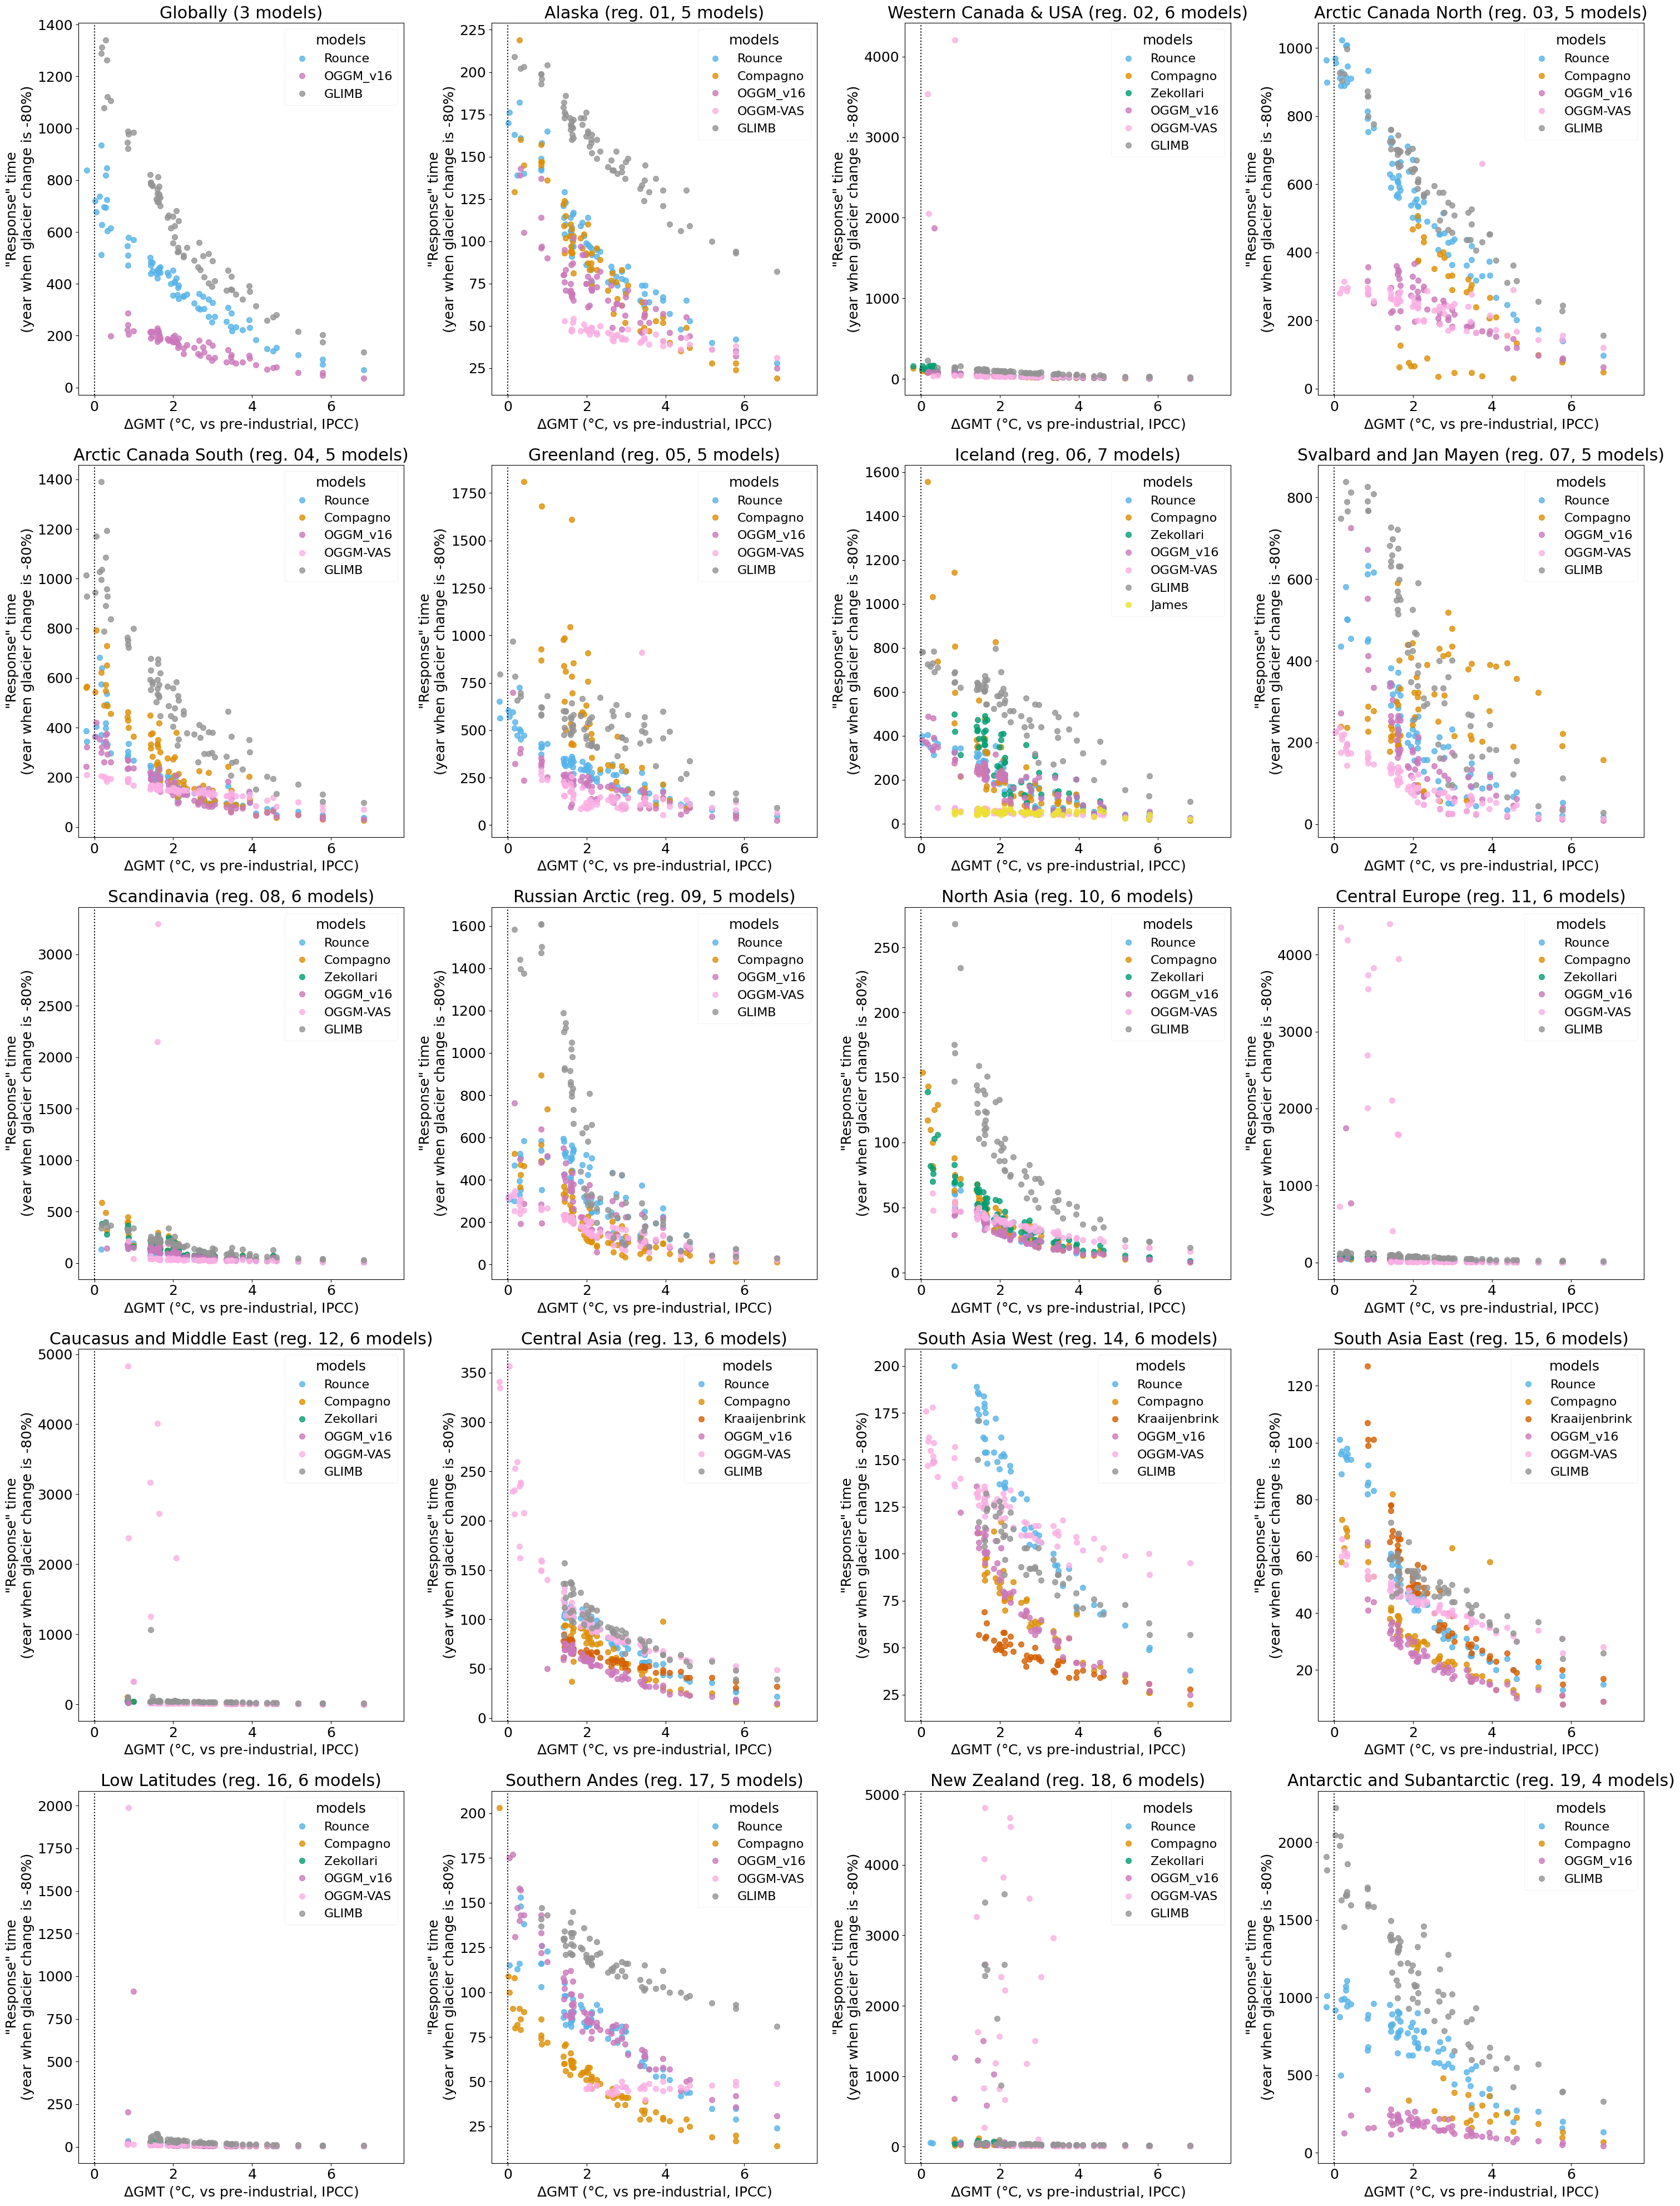

In [344]:
min_perc_change = 20 # at least 20% change is necessary to estimate a "response time"

rgi_num_order = ['All', '19', '03', '01', '05', '09', '04', '07', '17', '06', '13', '14',
                 '02', '15', '08', '10', '11', '16', '18', '12'] # after initial volume ...

pd_reg_models_count = ds_reg_models.volume_m3.sel(simulation_year=0).to_dataframe().groupby(['rgi_reg', 'model_author'])['volume_m3'].count().reset_index()
pd_reg_models_count = pd_reg_models_count.loc[pd_reg_models_count.rgi_reg !='All']
pd_reg_models_count = pd_reg_models_count.rename(columns={'volume_m3':'n_experiments'})
# models available for each region...
_regional_model = pd_reg_models_count.loc[pd_reg_models_count.n_experiments > 0 ] # ==80

## amount of models per region
reg_n_models = pd_reg_models_count.loc[pd_reg_models_count.n_experiments > 0].groupby('rgi_reg').count()['model_author'] # at least 1 experiment for that RGI region
# models that are globally available 
global_models = pd_reg_models_count.groupby('model_author').sum().where(pd_reg_models_count.groupby('model_author').sum() == 80 * 19).dropna().index

label_type = 'authors'
for perc in [-50, -80]: #,1999]:
    if perc>0:
        perc_change_i = f'+{perc}'
    else:
        perc_change_i = perc
    fig, axs = plt.subplots(5,4,figsize=(30,40)) #, sharey='row') #, sharex=True)
    rgi_regs_global = rgi_num_order
    rgi_regs_global = ['All', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12',
           '13', '14', '15', '16', '17', '18', '19'] #'All',
    for j, rgi_reg in enumerate(rgi_regs_global):
        if j<4:
            ax = axs[0][j]
        elif j <8:
            ax = axs[1][j-4]
        elif j <12:
            ax = axs[2][j-8]
        elif j <16:
            ax = axs[3][j-12]
        elif j <20:
            ax = axs[4][j-16]
        if rgi_reg == 'All':
            # only take models that exist globally
            # at the moment Rounce and Glimb, OGGM
            n = len(global_models)
            mj = 0
            for c,m in zip(pal_models, model_order):
                if m in global_models:
                    mj+=1
                    if label_type == 'anonymous':
                        label = f'model {mj}'
                    else:
                        label = m
                        
                    pd_category_resp_time = resp_time_estimate(model_author=m, perc_change_l=[perc],
                       rgi_reg=rgi_reg, min_perc_change=min_perc_change)

                    ax.plot(pd_category_resp_time['temp_ch_ipcc'],
                             pd_category_resp_time[f'resp_time_{perc_change_i}%'], 'o',
                             markersize=7, lw=0, color=c, label = label, alpha = 0.8)
                else:
                    pass

        else:    
            models_available = _regional_model.loc[_regional_model.rgi_reg==rgi_reg]['model_author'].values
            n = reg_n_models[rgi_reg]
            mj=0
            for c,m in zip(pal_models, model_order):
                if m in models_available:
                    mj+=1
                    if label_type == 'anonymous':
                        label = f'model {mj}'
                    else:
                        label = m
                    pd_category_resp_time = resp_time_estimate(model_author=m, perc_change_l=[perc],
                                                               rgi_reg=rgi_reg, min_perc_change=min_perc_change)

                    ax.plot(pd_category_resp_time['temp_ch_ipcc'],
                             pd_category_resp_time[f'resp_time_{perc_change_i}%'], 'o',
                             markersize=7, lw=0, color=c, label = label, alpha = 0.8)
                    

        handles, labels = ax.get_legend_handles_labels()
        #if j == 0 or j ==1:
        leg1 = ax.legend(handles, labels, title ='models', fontsize=16, framealpha=0.2, loc='upper right')
        #for c,m in zip(pal_models, ds_reg_models.model_author):
        # if I use max does not matter, I just do not 
        #ax.axhline(ds_reg_models.volume_m3.sel(simulation_year=0, rgi_reg=rgi_reg,model_author='GLIMB').max()/1e9, color='grey', label='initial volume') # , loc='upper right')
            #ax.axhspan(ds_reg_models.volume_m3.sel(simulation_year=0, rgi_reg=rgi_reg,model_author=m).min()/1e9,
        #                ds_reg_models.volume_m3.sel(simulation_year=0, rgi_reg=rgi_reg,model_author=m).max()/1e9, alpha =0.1, color =c, label='min_max')
        
        #leg1.remove():

        ax.set_ylabel(f'"Response" time\n(years when {perc_change_i}% of total change occurred)')

        ax.set_xlabel(f'$\Delta$GMT (°C, vs pre-industrial, IPCC)') # actually now: vs median global GCM 1850-1900  ... before vs median global GCM 1995-2014
        #med_initial_vol = ds_reg_models.volume_m3.sel(simulation_year=0, rgi_reg=rgi_reg,model_author='GLIMB').max().values/1e9
        #initial_vol = f'median: {med_initial_vol:.2f}km3'
        if rgi_reg != 'All':
            nam = d_reg_num_name[rgi_reg]
            ax.set_title(f'{nam} (reg. {rgi_reg}, {n} models)')
        else:
            ax.set_title(f'Globally ({n} models)')
        ax.axvline(0, ls=':', color='k')
        
        ax.set_xlim([-0.4070575502625482, 7.848015177053622])
        
    #plt.grid()
    plt.tight_layout()
    
    plt.savefig(f'figures/2_GlacierMIP3_resp_time_change{perc_change_i}%_regional_vs_GMT_change_IPCC.png') # path_analysis + 

In [ ]:
fig, axss= plt.subplots(2,2,figsize=(24,14))

# first subplot
axs = axss[0]
jj=0
model_author = 'OGGM_v16'
r
for ax, perc in zip(axs[0:2], [50,80]):

    
    
    
    
    sns.scatterplot(x='temp_ch_ipcc',
          y=f'Year when {perc}% of total change occured',
          data=pd_yr_perc_resp_time.loc[pd_yr_perc_resp_time.region == 'global'], ax=axss[1][jj], label='global')
    sns.scatterplot(x='temp_ch_ipcc',
          y=f'Year when {perc}% of total change occured',
          data=pd_yr_perc_resp_time.loc[pd_yr_perc_resp_time.region == 'RGI13'], ax=axss[1][jj], label='RGI13')
    sns.scatterplot(x='temp_ch_ipcc',
          y=f'Year when {perc}% of total change occured',
          data=pd_yr_perc_resp_time.loc[pd_yr_perc_resp_time.region == 'RGI11'], ax=axss[1][jj], label='RGI11')
    sns.scatterplot(x='temp_ch_ipcc',
          y=f'Year when {perc}% of total change occured',
          data=pd_yr_perc_resp_time.loc[pd_yr_perc_resp_time.region == 'RGI05'], ax=axss[1][jj], label='RGI05')
    if perc == 50:
        axss[1][jj].set_ylim([0,210])
    else:
        axss[1][jj].set_ylim([0,800])
    axss[1][jj].set_xlim([1.3,7.1])

    jj+=1
    
    
num_text_x = 0.007
for j,axi in enumerate([axs[0],axs[1]]): #0][1], axs[1][0], axs[1][1]]):
    #if j <2:
    num_text_y = 0.92
    #else:
    #    num_text_y = 0.87
    axi.text(num_text_x, num_text_y,
             num_dict[j], fontsize=26, transform=axi.transAxes)
    axi.axvspan(-0.5,0.5,color='grey', alpha = 0.1)
    axi.set_xlim([-0.5,19.5])
    
    
plt.tight_layout()
plt.savefig(f'figures/2_resp_time_rgi_region_analysis.png')

In [138]:
pd_yr_perc_resp_time

gcm   period_scenario  temp_ch_ipcc  \
0     gfdl-esm4    1851-1870_hist      0.171409   
1     gfdl-esm4    1901-1920_hist      0.418289   
2     gfdl-esm4    1951-1970_hist      0.332281   
3     gfdl-esm4    1995-2014_hist      0.841467   
4     gfdl-esm4  2021-2040_ssp126      1.433792   
..          ...               ...           ...   
75  ukesm1-0-ll  2061-2080_ssp370      4.379977   
76  ukesm1-0-ll  2061-2080_ssp585      5.170543   
77  ukesm1-0-ll  2081-2100_ssp126      2.978482   
78  ukesm1-0-ll  2081-2100_ssp370      5.780495   
79  ukesm1-0-ll  2081-2100_ssp585      6.824361   

    Year when 50% of total change occured  region  
0                                   190.0  global  
1                                   159.0  global  
2                                   100.0  global  
3                                   142.0  global  
4                                   134.0  global  
..                                    ...     ...  
75                                   94.0   RGI19  
76                                   89.0   RGI19  
77                                  267.0   RGI19  
78                                   51.0   RGI19  
79                                   41.0   RGI19  

[1600 rows x 5 columns]

In [ ]:
pd_global_temp_exp_m = get_glob_temp_exp(region='global')

ds_reg_models_vol = ds_reg_models.isel(simulation_year=slice(0,2000)).volume_m3
# Let's take the median/iqr estimate from all glacier models for every RGI region and then do the sum:
ds_reg_models_vol = ds_reg_models_vol.stack(experiments=['gcm','period_scenario'])

In [ ]:


### regional 
ds_reg_models_med_vol_2000 = 100*ds_reg_models_vol.median(dim='model_author').isel(simulation_year=1999)/ds_reg_models_vol.median(dim='model_author').isel(simulation_year=0)
# this here takes a while
#ds_reg_models_gcm_q25_q50_q75_vol = ds_reg_models_gcm_vol.quantile([0.25,0.5,0.75], dim='model_author')
# pd_global_temp_exp_m = get_glob_temp_exp(region=f'RGI{rgi_reg}_global') # pd_global_temp_exp.groupby(['gcm','period_scenario']).mean()
ds_reg_models_med_vol_2000 = ds_reg_models_med_vol_2000.assign_coords(temp_ch_ipcc = ('experiments',
                                                                                pd_global_temp_exp_m.loc[ds_reg_models_med_vol_2000.experiments.values, 'temp_ch_ipcc'].values))
ds_reg_models_med_vol_2000 = ds_reg_models_med_vol_2000.sortby('temp_ch_ipcc')
ds_reg_models_med_vol_2000 = ds_reg_models_med_vol_2000.reset_coords()
pd_reg_models_med_vol_2000 = ds_reg_models_med_vol_2000.to_dataframe().reset_index()
pd_reg_models_med_vol_2000['region'] = 'RGI' + pd_reg_models_med_vol_2000['rgi_reg']

### global
ds_glob_models_med_vol_2000 = 100*ds_reg_models_vol.median(dim='model_author').isel(simulation_year=1999).sum(dim='rgi_reg')/ds_reg_models_vol.median(dim='model_author').isel(simulation_year=0).sum(dim='rgi_reg')
ds_glob_models_med_vol_2000 = ds_glob_models_med_vol_2000.assign_coords(temp_ch_ipcc = ('experiments',
                                                                                pd_global_temp_exp_m.loc[ds_glob_models_med_vol_2000.experiments.values, 'temp_ch_ipcc'].values))
ds_glob_models_med_vol_2000 = ds_glob_models_med_vol_2000.sortby('temp_ch_ipcc')
ds_glob_models_med_vol_2000 = ds_glob_models_med_vol_2000.reset_coords()
pd_glob_models_med_vol_2000 = ds_glob_models_med_vol_2000.to_dataframe().reset_index()
pd_glob_models_med_vol_2000['region'] = 'global'

### concatenate both
pd_all_models_med_vol_2000 = pd.concat([pd_glob_models_med_vol_2000, pd_reg_models_med_vol_2000])

# get the % lost per °C (here from 1.5 - 3°C)
pd_all_models_med_vol_2000_sel_1o5_3 = pd_all_models_med_vol_2000.loc[(pd_all_models_med_vol_2000.temp_ch_ipcc>=1.5) & (pd_all_models_med_vol_2000.temp_ch_ipcc<=3)]

slope_rgi_dict = {}
pd_slope_rgi_reg_1o5_3 = pd.DataFrame(index=np.arange(0,20))
intercept_l = []
slope_l = []
rval_l = []
pval_l = []
stderr_l = []
region_l = []
for region in pd_all_models_med_vol_2000_sel_1o5_3.region.unique():
    pd_sel = pd_all_models_med_vol_2000_sel_1o5_3.loc[pd_all_models_med_vol_2000_sel_1o5_3.region==region]
    slope, intercept, rval, pval, stderr = scipy.stats.linregress(pd_sel['temp_ch_ipcc'].values, pd_sel['volume_m3'])
    slope_l.append(slope)
    intercept_l.append(intercept)
    stderr_l.append(stderr)
    rval_l.append(rval)
    pval_l.append(pval)
    region_l.append(region)
pd_slope_rgi_reg_1o5_3['slope'] = slope_l
pd_slope_rgi_reg_1o5_3['intercept'] = intercept_l
pd_slope_rgi_reg_1o5_3['stderr'] = stderr_l
pd_slope_rgi_reg_1o5_3['pval'] = pval_l
pd_slope_rgi_reg_1o5_3['rval'] = rval_l
pd_slope_rgi_reg_1o5_3['region'] = region_l


### Random old code...

In [ ]:
#global
#global
plt.rc('font', size=18)     
for rgi_reg in rgi_regs:
    fig,axs= plt.subplots(1,2,figsize=(24,8),sharey=True)
    plt.suptitle(f'RGI{rgi_reg} (Shading is 0.25 to 0.75 quantiles, i.e., the interquartile range)')
    ax = axs[0]
    ds_reg_models_med_vol_glob = ds_reg_models_med_vol.sel(rgi_reg=rgi_reg) #ds_reg_models_med_vol.sum(dim='rgi_reg')
    pd_global_temp_exp_m = get_glob_temp_exp(region='global')
    ds_reg_models_med_vol_glob = ds_reg_models_med_vol_glob.assign_coords(temp_ch_ipcc = ('experiments',
                                                                          pd_global_temp_exp_m.loc[ds_reg_models_med_vol_glob.experiments.values, 'temp_ch_ipcc'].values))
    # need that to have bot volume_m3 and temp_ch_ipcc as variables
    ds_reg_models_med_vol_glob = ds_reg_models_med_vol_glob.reset_coords()

    # normi = matplotlib.colors.Normalize(vmax=4, vmin=-4)
    pd_t =ds_reg_models_med_vol_glob.to_dataframe().reset_index()
    #pd_q25 =ds_reg_models_gcm_q25_q50_q75_vol_glob.sel(quantile=0.25).to_dataframe().reset_index()
    #pd_q75 =ds_reg_models_gcm_q25_q50_q75_vol_glob.sel(quantile=0.75).to_dataframe().reset_index()
    pd_t['volume (km3)'] = pd_t['volume_m3']/1e9
    #pd_q25['volume (km3)'] = pd_q25['volume_m3']/1e9
    #pd_q75['volume (km3)'] = pd_q75['volume_m3']/1e9
    sns.lineplot(ax=ax,
                 data=pd_t,
                 x='simulation_year',
                 y='volume (km3)',
                hue='temp_ch_ipcc', palette='flare',legend='auto',lw=1.5);
    leg = ax.get_legend()

    exp_temp_min = ds_reg_models_med_vol_glob.temp_ch_ipcc.idxmin()
    # only compute the quantile for the experiment w. minimum / maximum temperature, then just sum up the quantiles to get from regional to global estimates
    q25_75_min = ds_reg_models_vol.sel(experiments=exp_temp_min).quantile([0.25,0.75], dim='model_author')/1e9
    q25_75_min_glob = q25_75_min.sel(rgi_reg=rgi_reg)
    ax.fill_between(ds_reg_models_gcm_q25_q50_q75_vol_glob.simulation_year,
             q25_75_min_glob.sel(quantile=0.75), q25_75_min_glob.sel(quantile=0.25), alpha = 0.2, color=lines.lines[0].get_color(), label='IQR')
    handles, labels = ax.get_legend_handles_labels()
    t = plt.legend(handles, labels)
    ax.add_artist(leg)

    exp_temp_max = ds_reg_models_med_vol_glob.temp_ch_ipcc.idxmax()
    # only compute the quantile for the experiment w. minimum / maximum temperature, then just sum up the quantiles to get from regional to global estimates
    q25_75_max = ds_reg_models_vol.sel(experiments=exp_temp_max).quantile([0.25,0.75], dim='model_author')/1e9
    q25_75_max_glob = q25_75_max.sel(rgi_reg=rgi_reg)
    ax.fill_between(ds_reg_models_gcm_q25_q50_q75_vol_glob.simulation_year,
                    q25_75_max_glob.sel(quantile=0.75),
                    q25_75_max_glob.sel(quantile=0.25), alpha = 0.2, color=lines.lines[-1].get_color());
    ax.set_ylabel(f'RGI{rgi_reg} glacier volume (km³)')
    ax.get_legend().set_title(r'$\Delta$T (°C)')

    
    ax=axs[1]
    ax.set_title(f'RGI{rgi_reg} glacier volume (km³) after 2000 years')
    sns.scatterplot(ax=ax,
                    x='temp_ch_ipcc',
                 y='volume (km3)', data = pd_t.loc[pd_t.simulation_year==1999],
                hue='temp_ch_ipcc', palette='flare',legend='auto', s=80)

    ax.set_xlabel('Global temperature change (°C, compared to pre-industrial levels)')
    ax.get_legend().set_title(r'$\Delta$T (°C)')


    q25_75_2000 = ds_reg_models_vol.isel(simulation_year=1999).quantile([0.25,0.75], dim='model_author')/1e9
    q25_75_2000_glob = q25_75_2000.sel(rgi_reg=rgi_reg) #sum(dim='rgi_reg')

    q25_75_2000_glob = q25_75_2000_glob.assign_coords(temp_ch_ipcc = ('experiments',
                                                   pd_global_temp_exp_m.loc[ds_reg_models_med_vol_glob.experiments.values, 'temp_ch_ipcc'].values))
    q25_75_2000_glob = q25_75_2000_glob.reset_coords()

    q25_75_2000_glob = q25_75_2000_glob.sortby('temp_ch_ipcc')
    def smoothen(x, winsize=5):
        return np.array(pd.Series(x).rolling(winsize).mean())[winsize-1:]

    plt.fill_between(smoothen(q25_75_2000_glob.temp_ch_ipcc),
                     smoothen(q25_75_2000_glob.volume_m3.sel(quantile=0.25)),
                     smoothen(q25_75_2000_glob.volume_m3.sel(quantile=0.75)),
                     step='mid',
                     interpolate=True,
                     alpha = 0.2, color='grey');
    plt.tight_layout()
    plt.savefig(f'figures/2_timeseries_temp_ch_reg_glob/2_RGI{rgi_reg}_timeseries_vol_temp_ch.png')
    plt.close()

    
#########################
#############  Now the same but for regional glacier temperature change:#############
plt.rc('font', size=18)     
for rgi_reg in rgi_regs:
    fig,axs= plt.subplots(1,2,figsize=(24,8),sharey=True)
    plt.suptitle(f'RGI{rgi_reg} (Shading is 0.25 to 0.75 quantiles, i.e., the interquartile range)')
    ax = axs[0]
    ds_reg_models_med_vol_glob = ds_reg_models_med_vol.sel(rgi_reg=rgi_reg) #ds_reg_models_med_vol.sum(dim='rgi_reg')
    # add global temp. change to the dataset 
    pd_global_temp_exp_m = get_glob_temp_exp(region=f'RGI{rgi_reg}_global') # pd_global_temp_exp.groupby(['gcm','period_scenario']).mean()
    ds_reg_models_med_vol_glob = ds_reg_models_med_vol_glob.assign_coords(temp_ch_ipcc = ('experiments',
                                                                                pd_global_temp_exp_m.loc[ds_reg_models_med_vol_glob.experiments.values, 'temp_ch_ipcc'].values))
    # need that to have bot volume_m3 and temp_ch_ipcc as variables
    ds_reg_models_med_vol_glob = ds_reg_models_med_vol_glob.reset_coords()

    # normi = matplotlib.colors.Normalize(vmax=4, vmin=-4)
    pd_t =ds_reg_models_med_vol_glob.to_dataframe().reset_index()
    #pd_q25 =ds_reg_models_gcm_q25_q50_q75_vol_glob.sel(quantile=0.25).to_dataframe().reset_index()
    #pd_q75 =ds_reg_models_gcm_q25_q50_q75_vol_glob.sel(quantile=0.75).to_dataframe().reset_index()
    pd_t['volume (km3)'] = pd_t['volume_m3']/1e9
    #pd_q25['volume (km3)'] = pd_q25['volume_m3']/1e9
    #pd_q75['volume (km3)'] = pd_q75['volume_m3']/1e9
    sns.lineplot(ax=ax,
                 data=pd_t,
                 x='simulation_year',
                 y='volume (km3)',
                hue='temp_ch_ipcc', palette='flare',legend='auto',lw=1.5);
    leg = ax.get_legend()

    exp_temp_min = ds_reg_models_med_vol_glob.temp_ch_ipcc.idxmin()
    # only compute the quantile for the experiment w. minimum / maximum temperature, then just sum up the quantiles to get from regional to global estimates
    q25_75_min = ds_reg_models_vol.sel(experiments=exp_temp_min).quantile([0.25,0.75], dim='model_author')/1e9
    q25_75_min_glob = q25_75_min.sel(rgi_reg=rgi_reg)
    ax.fill_between(ds_reg_models_gcm_q25_q50_q75_vol_glob.simulation_year,
             q25_75_min_glob.sel(quantile=0.75), q25_75_min_glob.sel(quantile=0.25), alpha = 0.2, color=lines.lines[0].get_color(), label='IQR')
    handles, labels = ax.get_legend_handles_labels()
    t = plt.legend(handles, labels)
    ax.add_artist(leg)

    exp_temp_max = ds_reg_models_med_vol_glob.temp_ch_ipcc.idxmax()
    # only compute the quantile for the experiment w. minimum / maximum temperature, then just sum up the quantiles to get from regional to global estimates
    q25_75_max = ds_reg_models_vol.sel(experiments=exp_temp_max).quantile([0.25,0.75], dim='model_author')/1e9
    q25_75_max_glob = q25_75_max.sel(rgi_reg=rgi_reg)
    ax.fill_between(ds_reg_models_gcm_q25_q50_q75_vol_glob.simulation_year,
             q25_75_max_glob.sel(quantile=0.75), q25_75_max_glob.sel(quantile=0.25), alpha = 0.2, color=lines.lines[-1].get_color());
    ax.set_ylabel(f'RGI{rgi_reg} glacier volume (km³)')
    ax.get_legend().set_title(r'$\Delta$T (°C)'+'\nregional glacier')


    ax=axs[1]
    ax.set_title(f'RGI{rgi_reg} glacier volume (km³) after 2000 years')
    sns.scatterplot(ax=ax,
                    x='temp_ch_ipcc',
                 y='volume (km3)', data = pd_t.loc[pd_t.simulation_year==1999],
                hue='temp_ch_ipcc', palette='flare',legend='auto', s=80)
    
    ax.set_xlabel('Regional glacier temperature change (°C, compared to pre-industrial levels)')

    ax.get_legend().set_title(r'$\Delta$T (°C)'+'\nregional glacier');

    q25_75_2000 = ds_reg_models_vol.isel(simulation_year=1999).quantile([0.25,0.75], dim='model_author')/1e9
    q25_75_2000_glob = q25_75_2000.sel(rgi_reg=rgi_reg) #sum(dim='rgi_reg')

    q25_75_2000_glob = q25_75_2000_glob.assign_coords(temp_ch_ipcc = ('experiments',
                                                   pd_global_temp_exp_m.loc[ds_reg_models_med_vol_glob.experiments.values, 'temp_ch_ipcc'].values))
    q25_75_2000_glob = q25_75_2000_glob.reset_coords()

    q25_75_2000_glob = q25_75_2000_glob.sortby('temp_ch_ipcc')
    def smoothen(x, winsize=3):
        return np.array(pd.Series(x).rolling(winsize).mean())[winsize-1:]

    plt.fill_between(smoothen(q25_75_2000_glob.temp_ch_ipcc),
                     smoothen(q25_75_2000_glob.volume_m3.sel(quantile=0.25)),
                     smoothen(q25_75_2000_glob.volume_m3.sel(quantile=0.75)),
                     step='mid',
                     interpolate=True,
                     alpha = 0.2, color='grey');
    plt.tight_layout()
    plt.savefig(f'figures/2_timeseries_temp_ch_reg_glob/2_RGI{rgi_reg}_timeseries_vol_reg_glac_temp_ch.png')    
    plt.close()

In [ ]:
# OLD: just one GCM

gcm = 'gfdl-esm4'

pd_global_temp_exp_gcm = pd_global_temp_exp.loc[pd_global_temp_exp.gcm ==gcm]
ds_reg_models_gcm_vol = ds_reg_models.sel(gcm = gcm).isel(simulation_year=slice(0,2000)).volume_m3
# Let's take the median/iqr estimate from all glacier models for every RGI region and then do the sum:
ds_reg_models_gcm_med_vol = ds_reg_models_gcm_vol.median(dim='model_author')
# this here takes a while
ds_reg_models_gcm_q25_q50_q75_vol = ds_reg_models_gcm_vol.quantile([0.25,0.5,0.75], dim='model_author')
#global
ds_reg_models_gcm_q25_q50_q75_vol_glob = ds_reg_models_gcm_q25_q50_q75_vol.sum(dim='rgi_reg')
# add global temp. change to the dataset 
pd_global_temp_exp_gcm.index = pd_global_temp_exp_gcm.period_scenario
ds_reg_models_gcm_q25_q50_q75_vol_glob = ds_reg_models_gcm_q25_q50_q75_vol_glob.assign_coords(temp_ch_ipcc = ('period_scenario',
                                                                            pd_global_temp_exp_gcm.loc[ds_reg_models_gcm_q25_q50_q75_vol_glob.period_scenario.values, 'temp_ch_ipcc'].values))
# need that to have bot volume_m3 and temp_ch_ipcc as variables
ds_reg_models_gcm_q25_q50_q75_vol_glob = ds_reg_models_gcm_q25_q50_q75_vol_glob.reset_coords()

# normi = matplotlib.colors.Normalize(vmax=4, vmin=-4)
pd_t =ds_reg_models_gcm_q25_q50_q75_vol_glob.sel(quantile=0.5).to_dataframe().reset_index()
#pd_q25 =ds_reg_models_gcm_q25_q50_q75_vol_glob.sel(quantile=0.25).to_dataframe().reset_index()
#pd_q75 =ds_reg_models_gcm_q25_q50_q75_vol_glob.sel(quantile=0.75).to_dataframe().reset_index()
pd_t['volume (km3)'] = pd_t['volume_m3']/1e9
#pd_q25['volume (km3)'] = pd_q25['volume_m3']/1e9
#pd_q75['volume (km3)'] = pd_q75['volume_m3']/1e9
lines = sns.lineplot(data=pd_t,
             x='simulation_year',
             y='volume (km3)',
            hue='temp_ch_ipcc', palette='flare',legend='auto',lw=2);


period_ssp_temp_min = ds_reg_models_gcm_q25_q50_q75_vol_glob.temp_ch_ipcc.idxmin()
sel = ds_reg_models_gcm_q25_q50_q75_vol_glob.volume_m3.sel(period_scenario=period_ssp_temp_min)/1e9
plt.fill_between(ds_reg_models_gcm_q25_q50_q75_vol_glob.simulation_year,
         sel.sel(quantile=0.75), sel.sel(quantile=0.25), alpha = 0.2, color=lines.lines[0].get_color())

period_ssp_temp_max = ds_reg_models_gcm_q25_q50_q75_vol_glob.temp_ch_ipcc.idxmax()
sel = ds_reg_models_gcm_q25_q50_q75_vol_glob.volume_m3.sel(period_scenario=period_ssp_temp_max)/1e9
plt.fill_between(ds_reg_models_gcm_q25_q50_q75_vol_glob.simulation_year,
         sel.sel(quantile=0.75), sel.sel(quantile=0.25), alpha = 0.2, color=lines.lines[-1].get_color());


In [ ]:
for period_scenario in ds_reg_models_gcm_q25_q50_q75_vol_glob.period_scenario:
    ds_reg_models_gcm_q25_q50_q75_vol_glob
    plt.scatter(ds_reg_models_gcm_q25_q50_q75_vol_glob.simulation_year,
             ds_reg_models_gcm_q25_q50_q75_vol_glob.volume_m3.sel(quantile=0.5).sel(period_scenario=period_scenario),
               color=c);

In [ ]:


pd_global_temp_exp_gcm.index = pd_global_temp_exp_gcm.period_scenario

ds_reg_models_med_v_glob = ds_reg_models_med_v.sum(dim='rgi_reg')

# this is really unefficient
ds_reg_models_med_v_glob.to_dataframe().reset_index().pivot_table(values = 'volume_m3', index=)

In [4]:


pd_reg_models_med_v_glob =  ds_reg_models_med_v.sum(dim='rgi_reg').to_dataframe().reset_index().groupby(['period_scenario', 'simulation_year', 'gcm']).sum().reset_index()

pd_v_l = []
for gcm in ds_reg_models.gcm:
    pd_global_temp_exp_gcm = pd_global_temp_exp.loc[pd_global_temp_exp.gcm == 'gcm']
    ds_reg_models_med_v = ds_reg_models.volume_m3.median(dim='model_author').sel(gcm=gcm).sum(dim='rgi_reg')

    ds_reg_models_med_v = ds_reg_models_med_v.assign_coords(temp_ch_ipcc = ('period_ssp',
                                                                            pd_global_temp_exp_gcm.loc[pd_reg_models_med_v_glob.period_scenario, 'temp_ch_ipcc'].values))
    
    pd_v = ds_reg_models_med_v.to_dataframe().reset_index()
    pd_v['gcm'] = gcm.values
    pd_v_l.append(pd_v)
pd_glob_models_med_v = pd.concat(pd_v_l)

ds = pd_glob_models_med_v.groupby(['simulation_year','period_scenario', 'gcm']).mean().to_xarray()

d2000 = pd_glob_models_med_v.loc[pd_glob_models_med_v.simulation_year == 2000]

gcm   period_scenario  temp_ch_ipcc
0     gfdl-esm4    1851-1870_hist      0.171409
1     gfdl-esm4    1901-1920_hist      0.418289
2     gfdl-esm4    1951-1970_hist      0.332281
3     gfdl-esm4    1995-2014_hist      0.841467
4     gfdl-esm4  2021-2040_ssp126      1.433792
..          ...               ...           ...
75  ukesm1-0-ll  2081-2100_ssp370      5.780495
76  ukesm1-0-ll  2021-2040_ssp585      2.259733
77  ukesm1-0-ll  2041-2060_ssp585      3.586968
78  ukesm1-0-ll  2061-2080_ssp585      5.170544
79  ukesm1-0-ll  2081-2100_ssp585      6.824361

[80 rows x 3 columns]

In [ ]:
plt.plot(ds_reg_models_med_v.simulation_year, ds_reg_models_med_v.volume_m3.sum(dim='rgi_reg'));

In [ ]:

sns.scatterplot(data = pd_glob_models_med_v, x = 'simulation_year', hue='temp_ch_ipcc',
             y='volume_m3', palette='viridis');


sns.lineplot(data = d2000, x = 'temp_ch_ipcc',
             y='volume_m3', palette='viridis');